# Biodiversity Project : Bird songs analysis

In [2]:
import os
import numpy as np
import math

import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
import matplotlib.pyplot as plt
import librosa, librosa.display, IPython.display as ipd
import json
from mutagen.mp3 import MP3
from statistics import mean, median
import noisereduce as nr
import sklearn
import contextlib
import wave
from scipy.io import wavfile
import pandas as pd
from sklearn.preprocessing import minmax_scale

import pywt
import os
import numpy as np
import math
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, freqz, kaiser_beta, kaiserord, get_window
from scipy.signal import correlate, find_peaks
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


folder = "Bird_songs"  # chemin vers votre dossier

C:\Users\jardi\AppData\Local\Temp\ipykernel_11300\3525066380.py:8: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.signal import firwin, lfilter


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================
folder = "Bird_songs"
fs = 44100
lowcut = 100
highcut = 12000


# STEP 1 : FIR FILTER DESIGN

## 1.1 Déterminer les fréquences de coupures du filtre passe-bandes

In [4]:
wav_files = [f for f in os.listdir(folder) if f.endswith(".wav")]
                
if len(wav_files) == 0:
    print(f"ERROR: No .wav files found in '{folder}'")
else:
    print(f"\nFound {len(wav_files)} bird song files")
    print("="*80)


Found 10 bird song files


L'objectif est d’analyser le spectre fréquentiel de chaque enregistrement audio afin d’identifier automatiquement les fréquences les plus pertinentes pour le filtrage. En calculant la transformée de Fourier (FFT), on met en évidence les zones du spectre où l’énergie du signal est significative. L’idée théorique est que les fréquences où l’amplitude dépasse un certain seuil représentent la bande utile du signal, tandis que le reste correspond soit à du bruit, soit à des composantes non pertinentes.

Les fréquences de coupure « lowcut » et « highcut » sont donc choisies comme les premières et dernières fréquences au-dessus de ce seuil, ce qui permet de définir automatiquement une bande passante adaptée à chaque enregistrement. Le spectre ainsi que ces fréquences de coupure sont re^présentés sous forme de lignes verticales, offrant une interprétation claire de la zone fréquentielle où se situe réellement l’information utile dans chaque fichier audio.

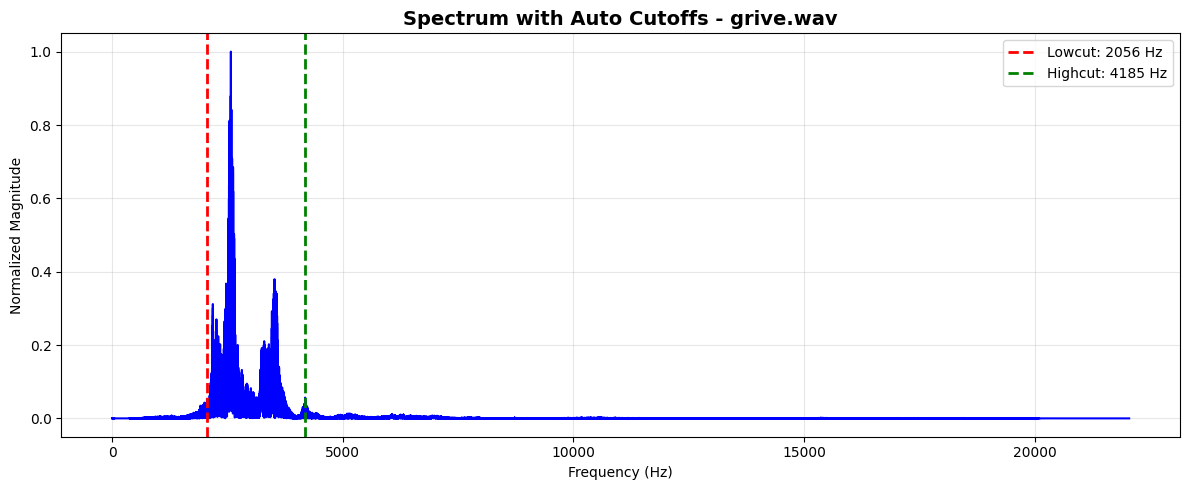

grive.wav -> Best lowcut: 2056.7 Hz, Best highcut: 4185.4 Hz


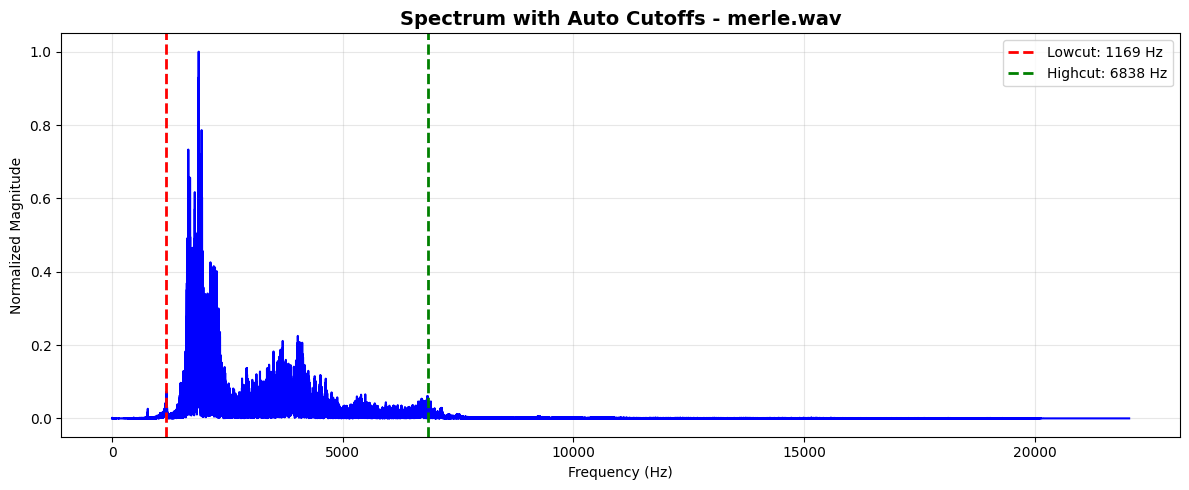

merle.wav -> Best lowcut: 1169.6 Hz, Best highcut: 6838.9 Hz


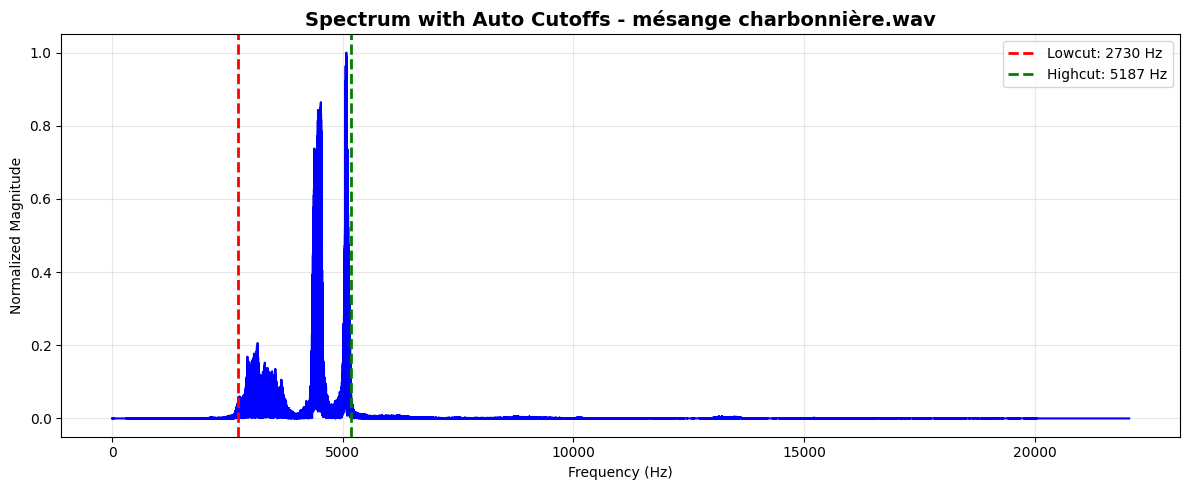

mésange charbonnière.wav -> Best lowcut: 2730.0 Hz, Best highcut: 5187.2 Hz


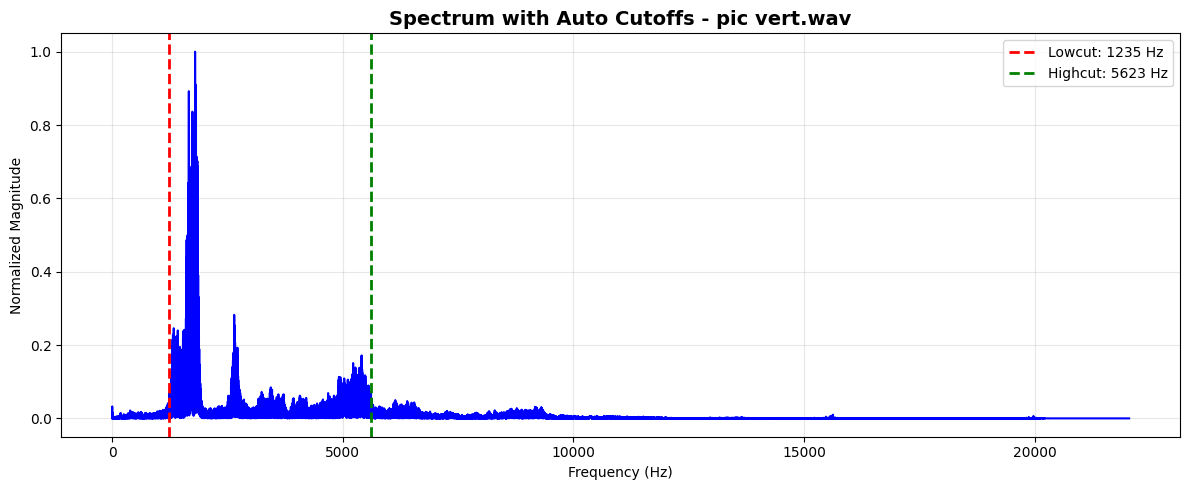

pic vert.wav -> Best lowcut: 1235.7 Hz, Best highcut: 5623.4 Hz


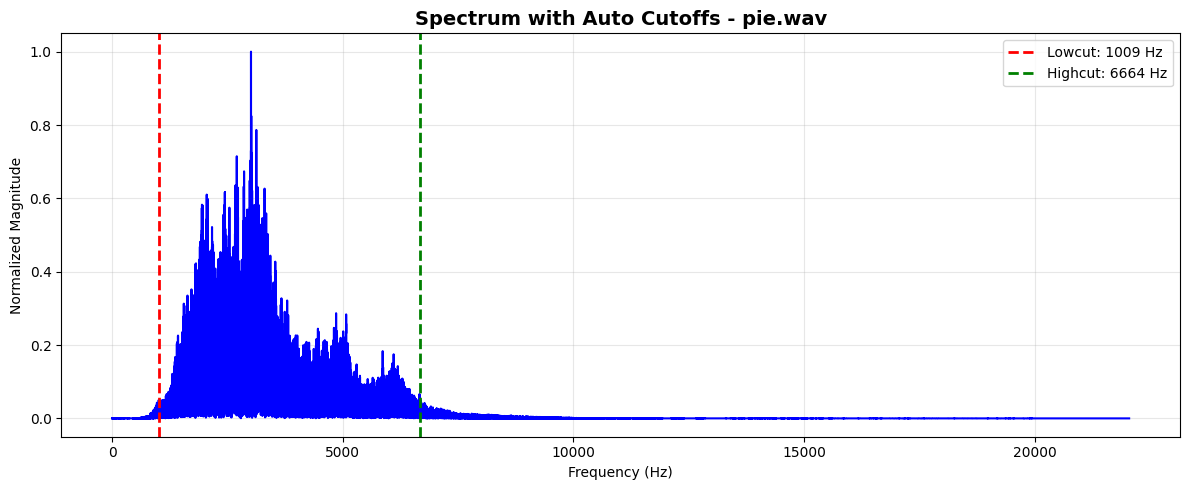

pie.wav -> Best lowcut: 1009.8 Hz, Best highcut: 6664.3 Hz


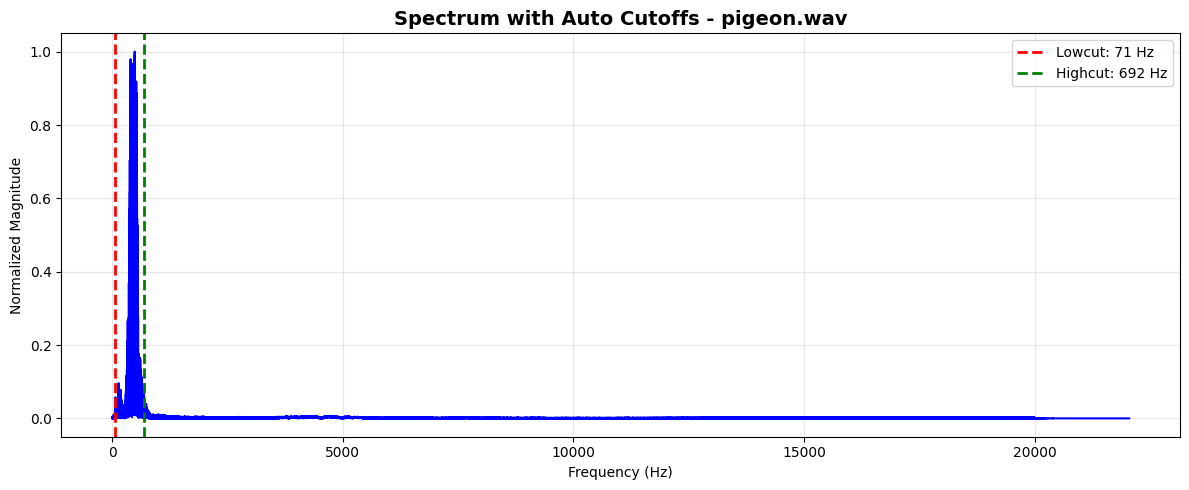

pigeon.wav -> Best lowcut: 71.8 Hz, Best highcut: 692.2 Hz


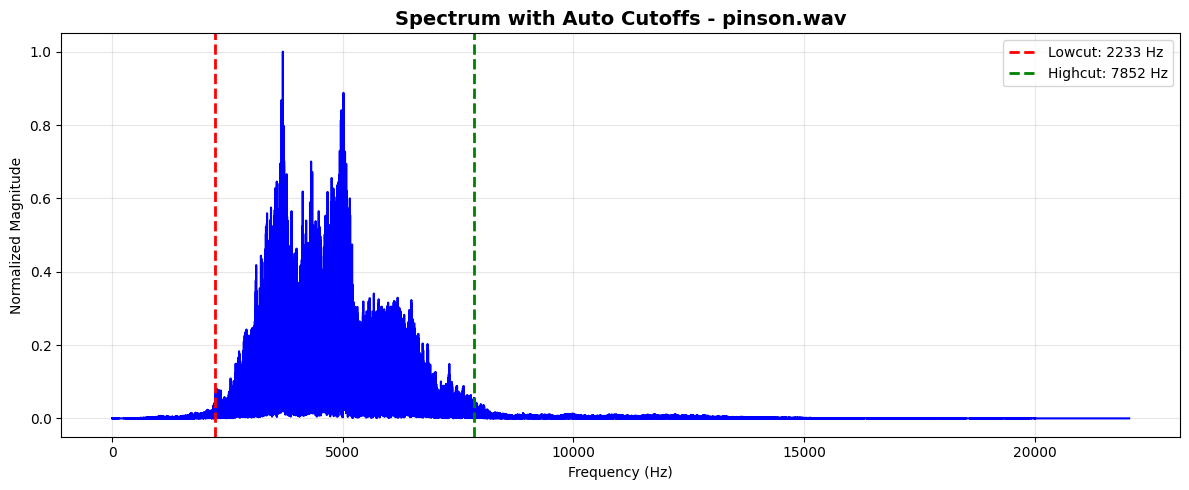

pinson.wav -> Best lowcut: 2233.9 Hz, Best highcut: 7852.3 Hz


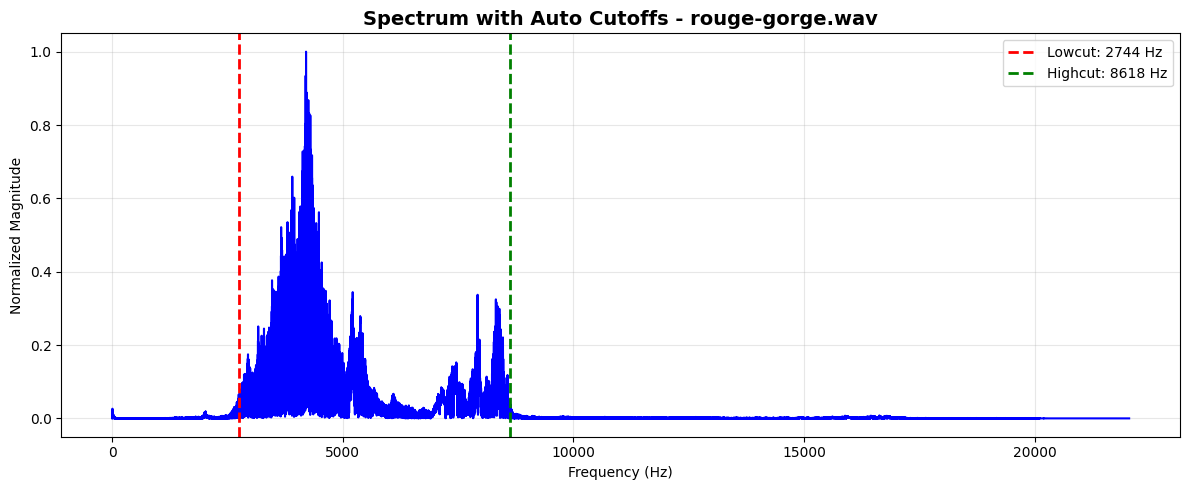

rouge-gorge.wav -> Best lowcut: 2744.5 Hz, Best highcut: 8618.3 Hz


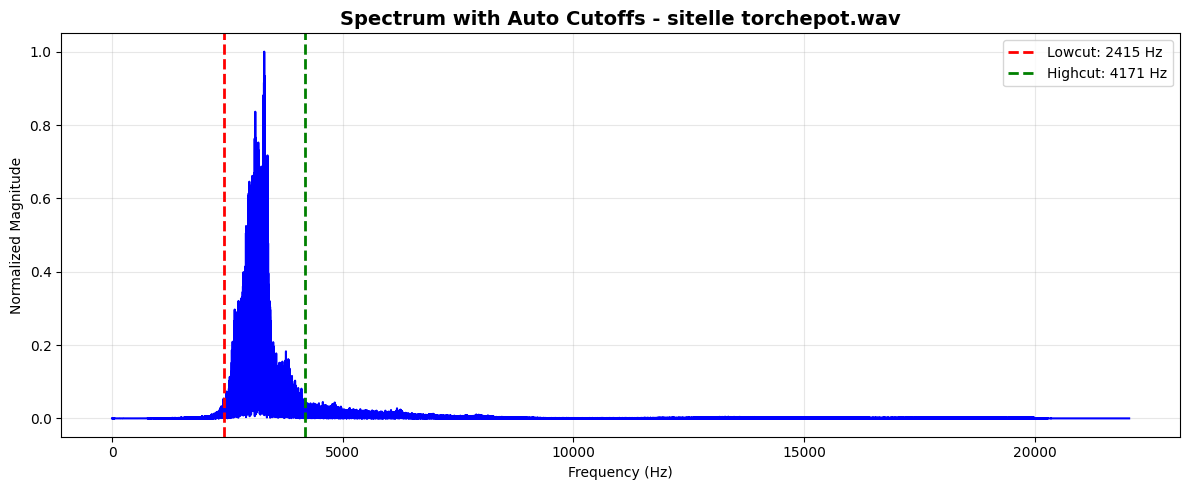

sitelle torchepot.wav -> Best lowcut: 2415.9 Hz, Best highcut: 4171.7 Hz


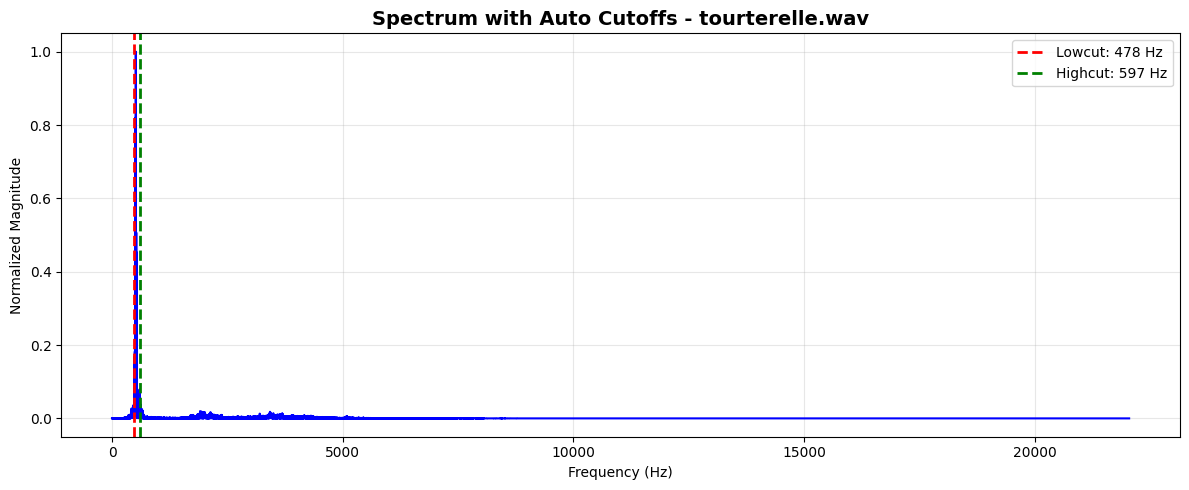

tourterelle.wav -> Best lowcut: 478.2 Hz, Best highcut: 597.2 Hz


In [5]:


lowcuts = []
highcuts = []
def plot_spectrum_with_cutoffs(wav_files, folder, fs, threshold=10):
    """
    Plot the power spectrum of each WAV file and indicate the automatically 
    selected lowcut and highcut frequencies based on significant energy.
    
    Parameters:
    - wav_files: list of .wav files
    - folder: path to audio files
    - fs: sampling rate
    - threshold: fraction of max magnitude to define significant energy
    """
    
    for wav_file in wav_files:
        filepath = os.path.join(folder, wav_file)
        y, sr = librosa.load(filepath, sr=fs)
        
        # Compute FFT
        freqs = np.fft.rfftfreq(len(y), 1/fs)
        spectrum = np.abs(np.fft.rfft(y))
        spectrum = spectrum / np.max(spectrum)  # normalize
        
        # Determine cutoff frequencies based on threshold
        significant = freqs[spectrum >= threshold]
        if len(significant) == 0:
            print(f"Warning: no significant energy found in {wav_file}")
            continue
        lowcut = significant[0]
        highcut = significant[-1]
        lowcuts.append(lowcut)
        highcuts.append(highcut)
        
        # Plot spectrum
        plt.figure(figsize=(12, 5))
        plt.plot(freqs, spectrum, 'b', linewidth=1.5)
        plt.axvline(lowcut, color='r', linestyle='--', linewidth=2, label=f'Lowcut: {int(lowcut)} Hz')
        plt.axvline(highcut, color='g', linestyle='--', linewidth=2, label=f'Highcut: {int(highcut)} Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalized Magnitude')
        plt.title(f'Spectrum with Auto Cutoffs - {wav_file}', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"{wav_file} -> Best lowcut: {lowcut:.1f} Hz, Best highcut: {highcut:.1f} Hz")

# Example usage
plot_spectrum_with_cutoffs(wav_files, folder, fs, threshold=0.05)


## 1.2 Comparaison des fenêtres

La fonction test_window_functions évalue l'effet de différentes fonctions de fenêtre sur la conception de filtres FIR (Finite Impulse Response) pour les signaux audio, ici spécifiquement les chants d'oiseaux. Les filtres FIR sont largement utilisés pour leur stabilité et leur phase linéaire, et le choix de la fenêtre affecte considérablement la réponse en fréquence, y compris la bande passante de transition et la suppression des lobes secondaires. La fonction prend en entrée une liste de fichiers audio (wav_files), un chemin d'accès au dossier (folder), un taux d'échantillonnage (fs), des fréquences de coupure (lowcut et highcut) et un ordre de filtre N (par défaut 1200).

Elle sélectionne aléatoirement trois fichiers audio et les charge avec librosa. Une grille de sous-graphiques 3×3 est créée pour comparer les réponses en fréquence des filtres conçus avec différentes fenêtres : Hamming, Hann, Blackman, Kaiser (avec β), Rectangular, Bartlett, Flattop, Tukey et Bohman. Chaque filtre est conçu à l'aide de firwin, et sa réponse en fréquence est calculée avec freqz et représentée en décibels. Les graphiques comprennent des lignes de coupure et des niveaux de référence (-3 dB et -40 dB) pour visualiser les performances. Chaque figure est enregistrée et affichée, ce qui permet une comparaison qualitative de l'impact du choix de la fenêtre sur les caractéristiques du filtre, telles que la largeur du lobe principal et l'atténuation des lobes secondaires, fournissant ainsi une démonstration claire des effets de la fenêtre dans le filtrage FIR des enregistrements de chants d'oiseaux.


STEP 1.2: TESTING WINDOW FUNCTIONS


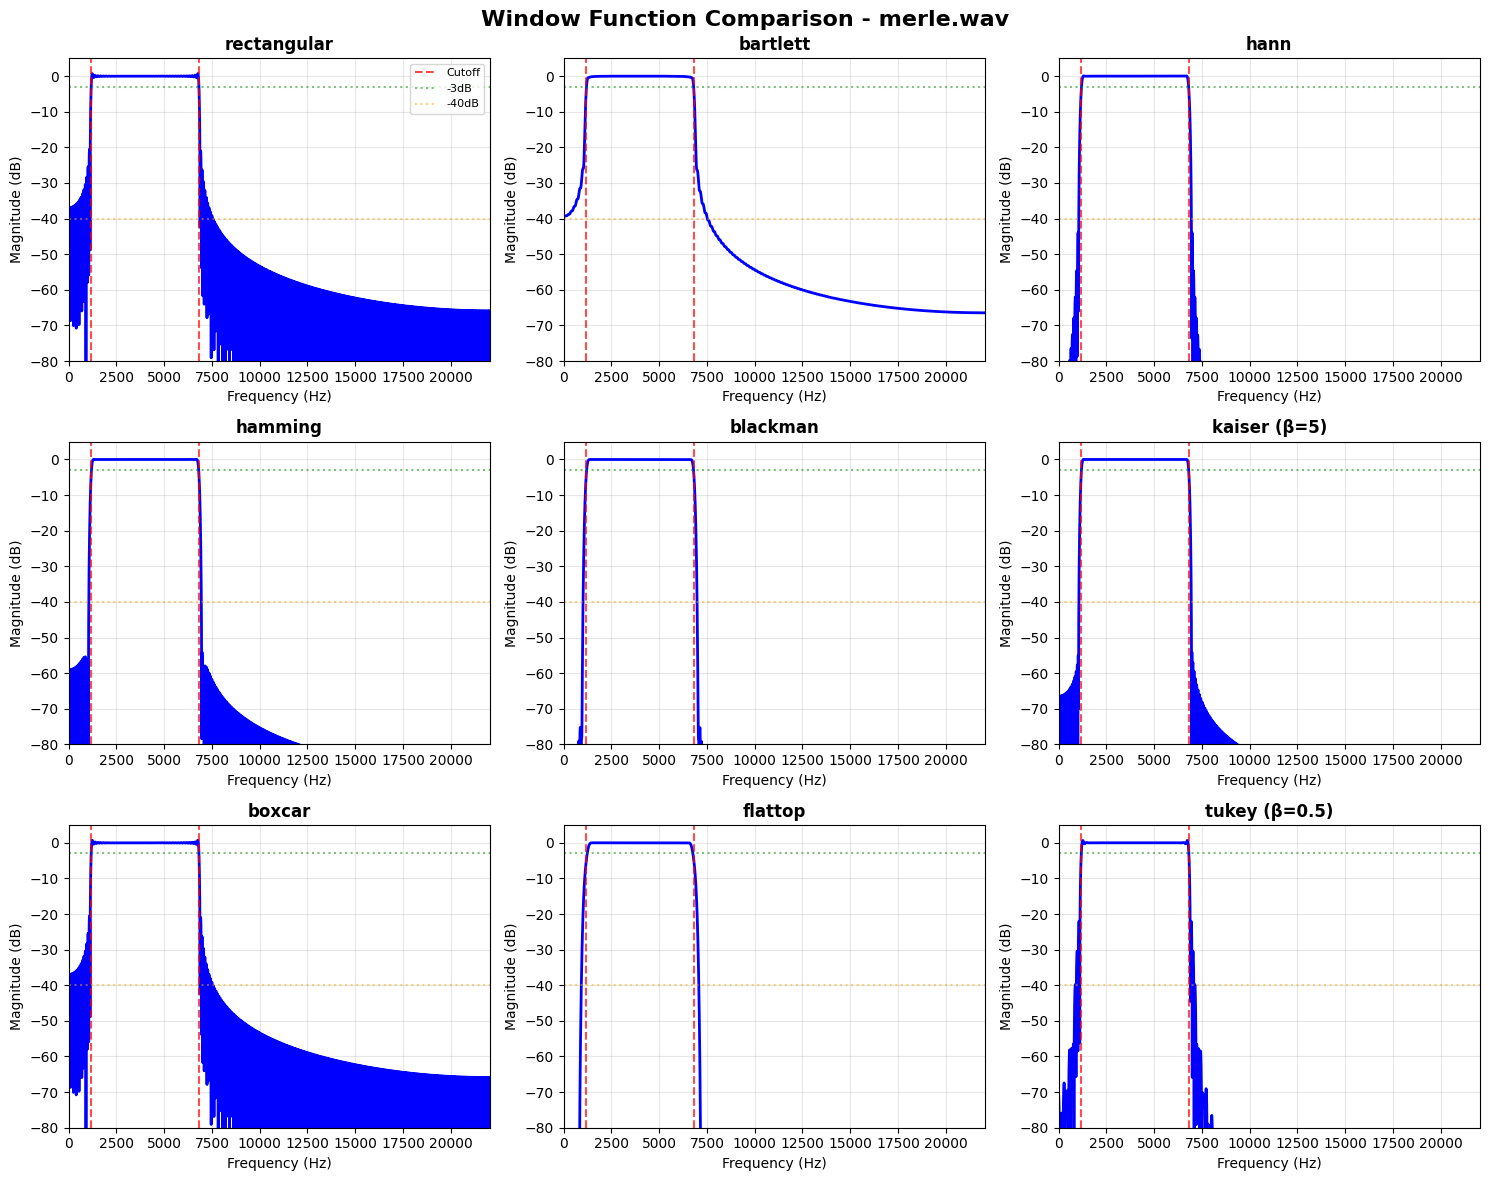

✓ Completed window analysis for merle.wav


In [6]:
# ============================================================================
# STEP 2: FIR FILTER WITH DIFFERENT WINDOW FUNCTIONS
# ============================================================================
def test_window_functions(wav_files, folder, fs, lowcut, highcut, N=1200, file_index=0):
    """
    Test different window functions for FIR filter design.
    
    Windows tested:
    - Hamming: Good general purpose, moderate side lobe suppression
    - Hann: Similar to Hamming, smoother
    - Blackman: Excellent side lobe suppression, wider transition
    - Kaiser (β=5): Adjustable tradeoff parameter
    - Rectangular: Narrowest transition, worst side lobes
    - Bartlett: Triangular, poor performance
    - Flattop: Excellent amplitude accuracy
    - Tukey: Hybrid rectangular-Hann
    - Bohman: Convolution of Bartlett with itself
    """
    print("=" * 80)
    print("STEP 1.2: TESTING WINDOW FUNCTIONS")
    print("=" * 80)
    
    windows = ['rectangular','bartlett','hann','hamming', 'blackman', ('kaiser', 5), 
               'boxcar',  'flattop', ('tukey', 0.5)]
    
    # Select 3 random bird songs
    selected_files = wav_files[file_index:file_index+1]
    
    for bird_idx, filename in enumerate(selected_files):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        fig.suptitle(f'Window Function Comparison - {filename}', fontsize=16, fontweight='bold')
        axes = axes.flatten()
        
        for win_idx, window in enumerate(windows):
            # Design filter with specific window
            bp_filter = firwin(N + 1, [lowcut, highcut], pass_zero=False, 
                             fs=fs, window=window)
            
            # Get frequency response
            w, h = freqz(bp_filter, worN=8000, fs=fs)
            h_dB = 20 * np.log10(np.abs(h) + 1e-10)
            
            # Plot
            ax = axes[win_idx]
            ax.plot(w, h_dB, 'b', linewidth=2)
            ax.axvline(lowcut, color='r', linestyle='--', alpha=0.7, label='Cutoff')
            ax.axvline(highcut, color='r', linestyle='--', alpha=0.7)
            ax.axhline(-3, color='g', linestyle=':', alpha=0.5, label='-3dB')
            ax.axhline(-40, color='orange', linestyle=':', alpha=0.5, label='-40dB')
            ax.grid(True, alpha=0.3)
            ax.set_xlim([0, fs/2])
            ax.set_ylim([-80, 5])
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Magnitude (dB)')
            
            window_name = window if isinstance(window, str) else f"{window[0]} (β={window[1]})"
            ax.set_title(f'{window_name}', fontweight='bold')
            
            if win_idx == 0:
                ax.legend(fontsize=8)
        
        plt.tight_layout()
        plt.savefig(f'window_comparison_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✓ Completed window analysis for {filename}")


file_index = 1  # Index of the file to analyze
# Execute all analysis steps
try:
    # Step 1.2: Window function testing
    test_window_functions(wav_files, folder, fs, lowcuts[file_index], highcuts[file_index], N=600, file_index=file_index)

except Exception as e:
            print(f"\nERROR during analysis: {e}")

window = 'hann'  # Selected window type

# 1.3 Comparaison de l'ordre N du filtre

Ce code vise à estimer puis illustrer l’impact de l’ordre du filtre FIR dans la conception d’un filtre passe-bande. La première partie utilise la formule du filtre de Kaiser, une approche théorique permettant de déterminer un ordre minimal en fonction de l’atténuation souhaitée dans la bande coupée et de la largeur de transition du filtre. Cette relation repose sur le compromis fondamental entre précision spectrale et complexité : une atténuation plus forte ou une transition plus étroite nécessite un ordre plus élevé, donc un filtre plus long. Le paramètre β du Kaiser, également calculé ici, ajuste la forme de la fenêtre pour atteindre l’atténuation spécifiée.

La seconde partie du code illustre concrètement ces choix en appliquant plusieurs ordres de filtre prédéfinis à un enregistrement audio et en représentant leur réponse fréquentielle. En comparant ces réponses, on visualise clairement comment l’ordre du filtre influence la largeur de la transition, la finesse de la bande passante et le niveau d’atténuation hors bande. Cela permet de choisir un ordre adapté en tenant compte à la fois des performances fréquentielles désirées et des contraintes de calcul.


STEP 1.3: FILTER ORDER CALCULATION
Atten: 40dB, Trans: 100Hz → N=491, β=3.40
Atten: 40dB, Trans: 200Hz → N=245, β=3.40
Atten: 40dB, Trans: 500Hz → N=98, β=3.40
Atten: 60dB, Trans: 100Hz → N=798, β=5.65
Atten: 60dB, Trans: 200Hz → N=399, β=5.65
Atten: 60dB, Trans: 500Hz → N=159, β=5.65
Atten: 80dB, Trans: 100Hz → N=1105, β=7.86
Atten: 80dB, Trans: 200Hz → N=552, β=7.86
Atten: 80dB, Trans: 500Hz → N=221, β=7.86


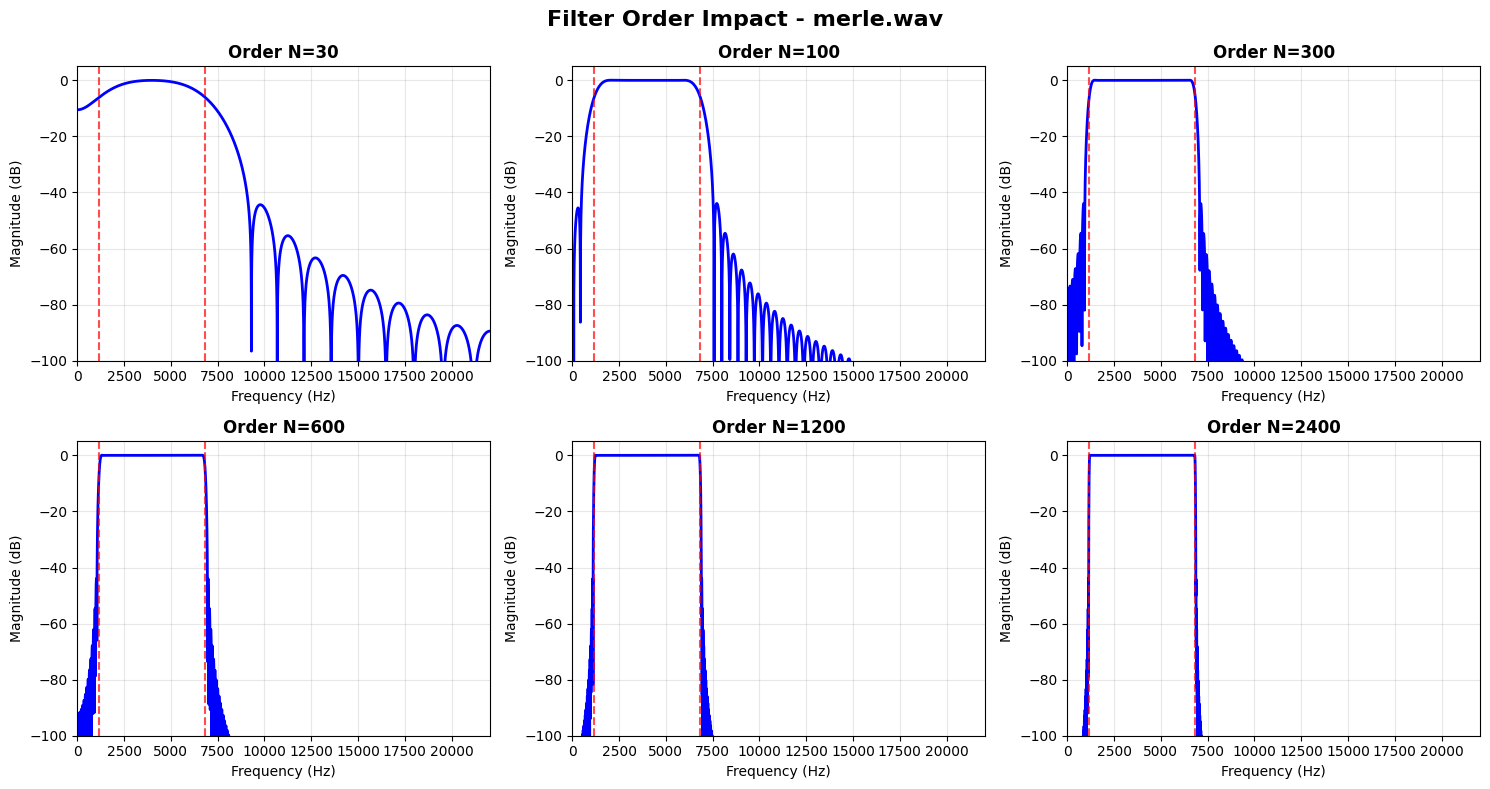

In [7]:
# ============================================================================
# STEP 1.3: FILTER ORDER CALCULATION AND TESTING
# ============================================================================
def calculate_and_test_filter_orders(wav_files, folder, fs, lowcut, highcut, file_index=0):
    """
    Calculate optimal filter order using Kaiser formula.
    
    Formula: N ≈ (A_s - 8) / (2.285 * Δω)
    where:
    - A_s: desired stopband attenuation (dB)
    - Δω: transition width (normalized frequency)
    """
    print("\n" + "=" * 80)
    print("STEP 1.3: FILTER ORDER CALCULATION")
    print("=" * 80)
    
    # Test different parameters
    attenuations = [40, 60, 80]  # stopband attenuation in dB
    transition_widths = [100, 200, 500]  # Hz
    
    results = []
    
    for atten in attenuations:
        for trans_width in transition_widths:
            # Normalized transition width
            delta_f = trans_width / (fs / 2)
            
            # Kaiser formula
            N_est = int((atten - 8) / (2.285 * 2 * np.pi * delta_f))
            
            # Kaiser beta parameter
            if atten > 50:
                beta = 0.1102 * (atten - 8.7)
            elif atten >= 21:
                beta = 0.5842 * (atten - 21)**0.4 + 0.07886 * (atten - 21)
            else:
                beta = 0
            
            results.append({
                'Attenuation (dB)': atten,
                'Transition (Hz)': trans_width,
                'Order N': N_est,
                'Beta': f'{beta:.2f}'
            })
            
            print(f"Atten: {atten}dB, Trans: {trans_width}Hz → N={N_est}, β={beta:.2f}")
    
    # Test with one bird song
    filename = wav_files[file_index]
    filepath = os.path.join(folder, filename)
    y, sr = librosa.load(filepath, sr=fs)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Filter Order Impact - {filename}', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    test_orders = [30, 100, 300, 600, 1200, 2400]
    
    for idx, N_test in enumerate(test_orders):
        bp_filter = firwin(N_test + 1, [lowcut, highcut], pass_zero=False, 
                          fs=fs, window=window)
        w, h = freqz(bp_filter, worN=8000, fs=fs)
        h_dB = 20 * np.log10(np.abs(h) + 1e-10)
        
        ax = axes[idx]
        ax.plot(w, h_dB, 'b', linewidth=2)
        ax.axvline(lowcut, color='r', linestyle='--', alpha=0.7)
        ax.axvline(highcut, color='r', linestyle='--', alpha=0.7)
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, fs/2])
        ax.set_ylim([-100, 5])
        ax.set_title(f'Order N={N_test}', fontweight='bold')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Magnitude (dB)')
    
    plt.tight_layout()
    plt.savefig('filter_order_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return results

# Step 1.3: Filter order calculation
filter_results = calculate_and_test_filter_orders(wav_files, folder, fs, lowcuts[file_index], highcuts[file_index], file_index=file_index)
N = 1200  # Selected filter order based on analysis

# 2. Analyse des syllabes

## 2.1 Analyse FFT et performance du filtre pour déterminer les syllabes 

Ce code réalise une analyse complète destinée à détecter automatiquement les syllabes présentes dans des enregistrements de chants d’oiseaux en s’appuyant à la fois sur l’analyse fréquentielle et sur l’énergie du signal filtré. Il commence par appliquer un filtre passe-bande FIR, dont les fréquences de coupure ont été déterminées au préalable, afin de ne conserver que la zone spectrale où les vocalisations sont réellement présentes. Cette étape réduit fortement le bruit et rend les variations d’énergie plus représentatives des syllabes.

Le signal filtré est ensuite segmenté en fenêtres successives pour calculer son énergie frame par frame : cette mesure permet de repérer les instants où l’oiseau produit effectivement une émission sonore. Un seuil adaptatif est construit à partir de la moyenne et de l’écart-type de l’énergie, ce qui permet de détecter de manière robuste les passages énergétiques correspondant aux syllabes. Les frontières de ces syllabes sont ensuite extraites, et les segments trop courts — probablement du bruit ou des artefacts — sont éliminés.

Pour faciliter l’interprétation, le code génère deux visualisations : le signal temporel où les syllabes détectées sont mises en évidence, et l’évolution de l’énergie avec le seuil de détection représenté explicitement. L’ensemble permet de comprendre à la fois la structure temporelle du chant et l’efficacité du filtrage et du seuil énergétique dans l’identification des syllabes. Enfin, un résumé indique pour chaque fichier le nombre total de syllabes détectées et leur taux par seconde, fournissant une mesure quantitative utile pour des analyses comportementales ou bioacoustiques.


STEP 2.1: FFT ANALYSIS & FILTER PERFORMANCE TO DETERMINE SYLLABLES


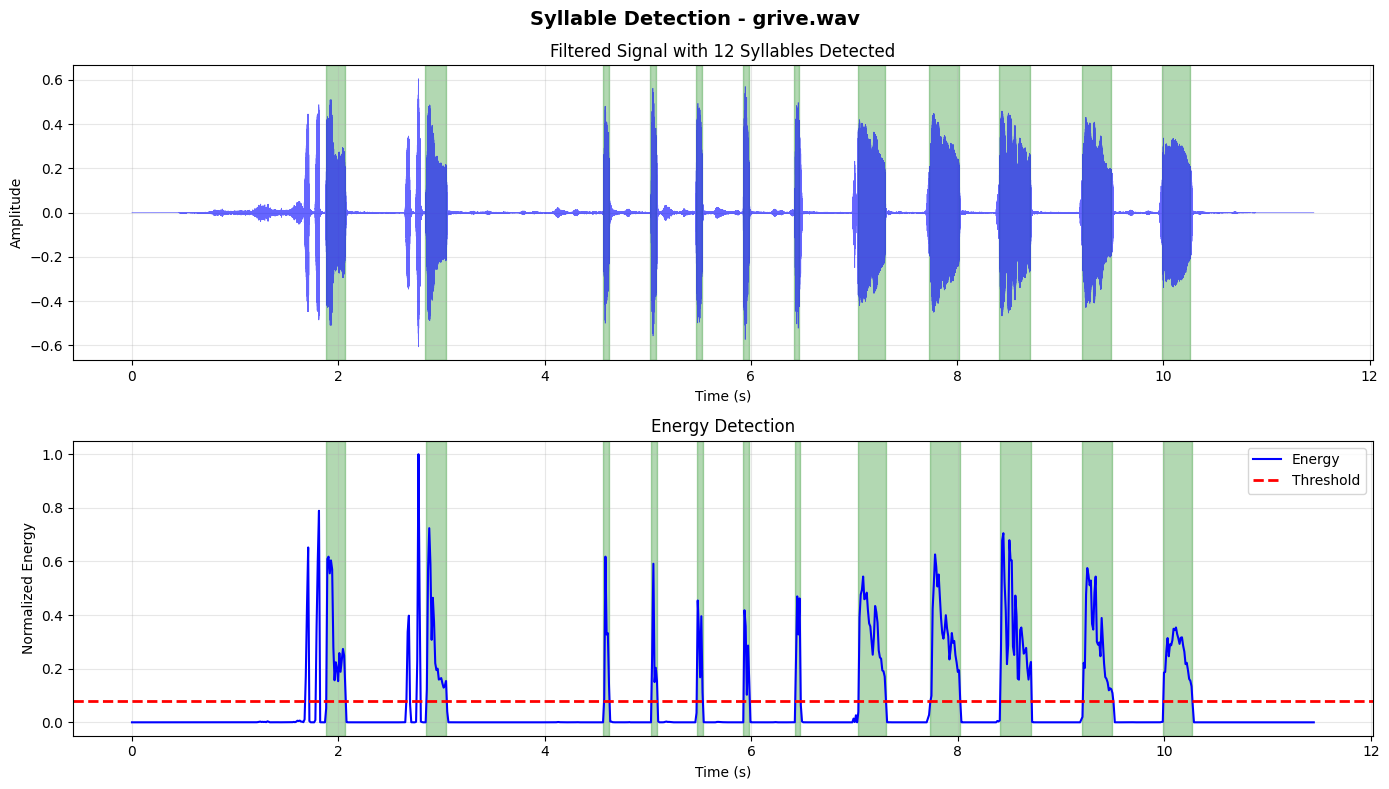

✓ grive.wav: 12 syllables detected (1.05 syllables/sec)


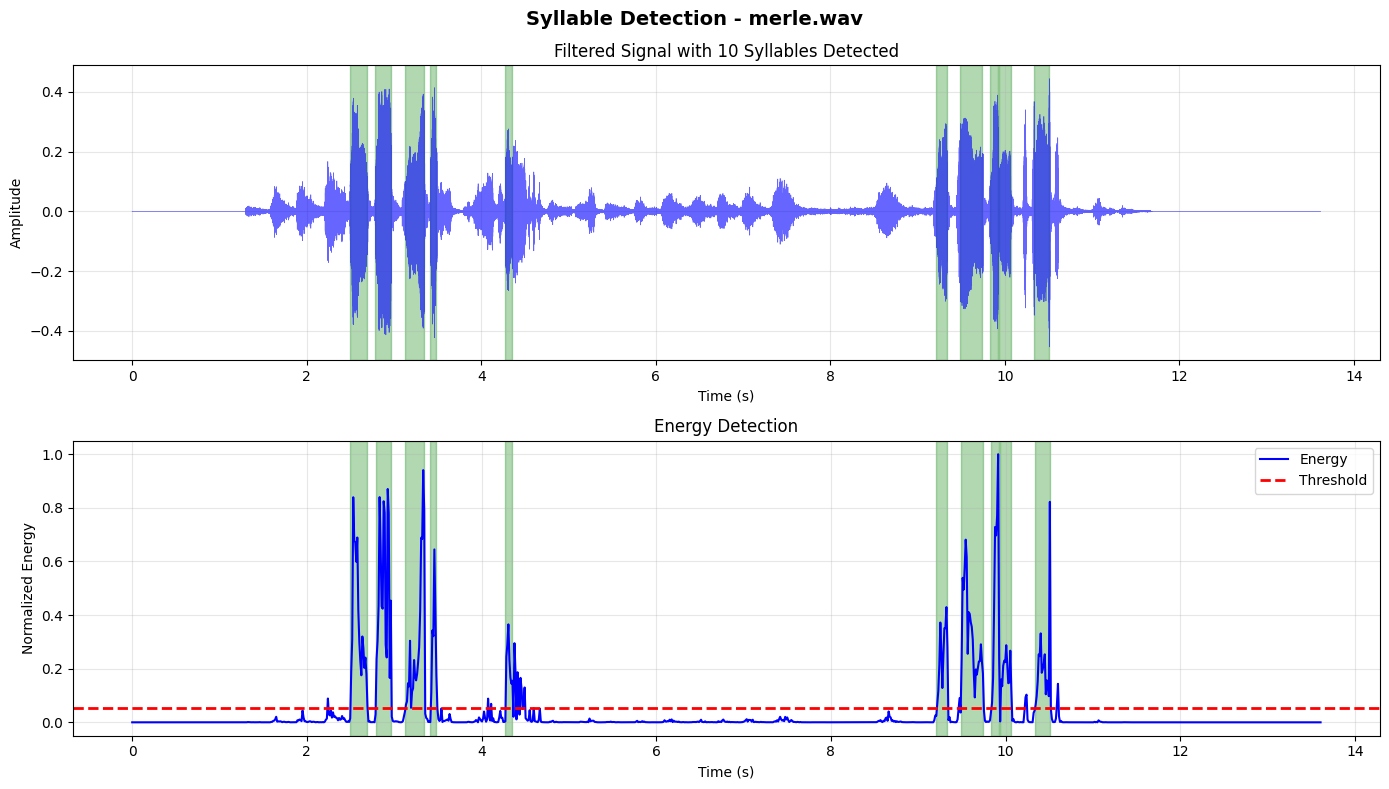

✓ merle.wav: 10 syllables detected (0.73 syllables/sec)


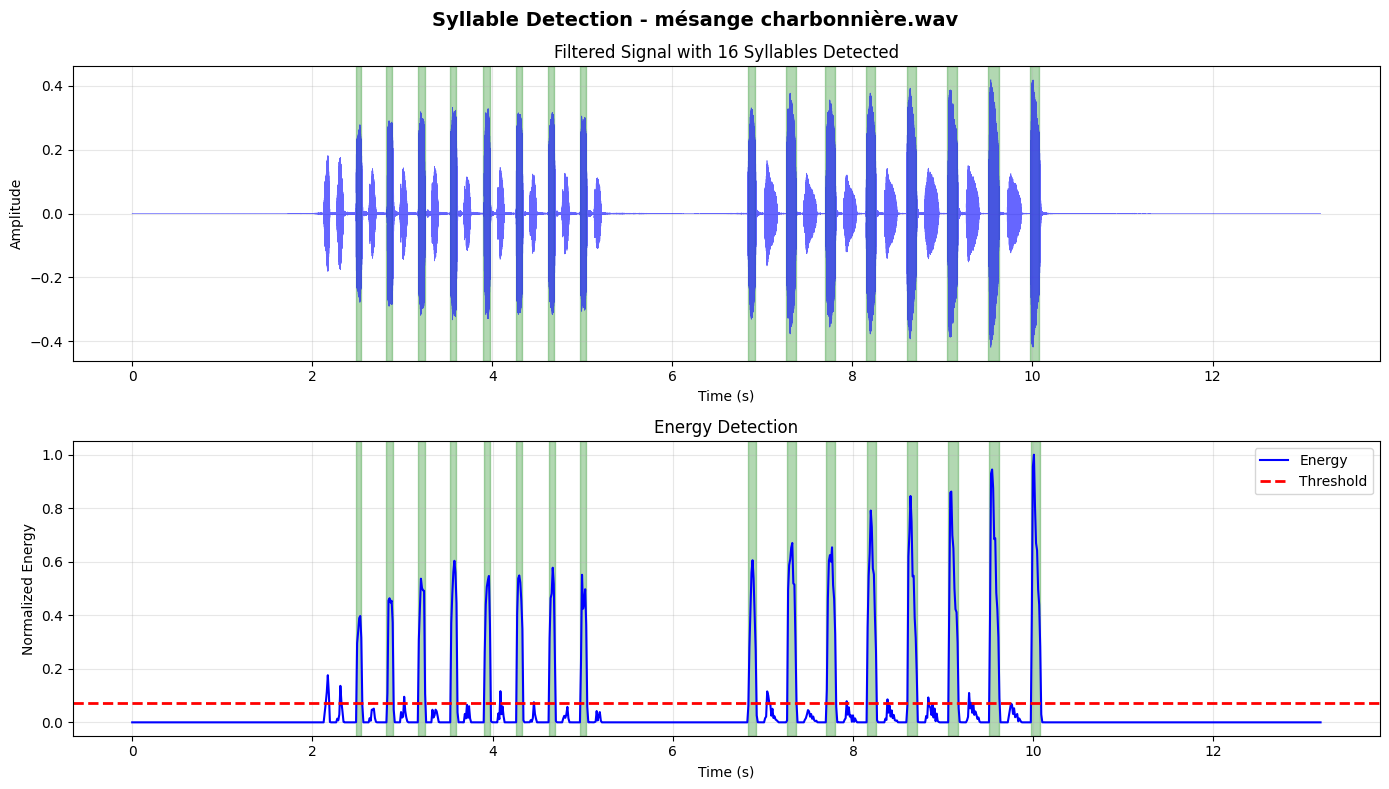

✓ mésange charbonnière.wav: 16 syllables detected (1.21 syllables/sec)

SYLLABLE COUNTING SUMMARY:
mésange charbonnière.wav       |  16 syllables | 13.20s | 1.21 syll/s


[{'file': 'mésange charbonnière.wav',
  'syllables': 16,
  'duration': 13.200544217687074,
  'syllables_per_sec': 1.212071240105541}]

In [8]:
# ============================================================================
# STEP 2.1: FFT ANALYSIS AND FILTER PERFORMANCE TO DETERMINE SYLLABLES
# ============================================================================
def fft_analysis_and_filter_test(wav_files, folder, fs, N=1200, k = 0.8):
    """
    Perform FFT analysis to find dominant frequencies.
    Test filter performance on time and frequency domains.
    """
    print("\n" + "=" * 80)
    print("STEP 2.1: FFT ANALYSIS & FILTER PERFORMANCE TO DETERMINE SYLLABLES")
    print("=" * 80)
    
    
    
    for bird_idx, filename in enumerate(wav_files[:3]):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        bp_filter = firwin(N + 1, [lowcuts[bird_idx], highcuts[bird_idx]], pass_zero=False, fs=fs, window=window)
        
        # Apply filter
        y_filt = lfilter(bp_filter, 1.0, y)
        
        # Compute energy
        frame_length = 50
        hop_length = 512
        energy = np.array([
            np.sum(y_filt[i:i+frame_length]**2)
            for i in range(0, len(y_filt)-frame_length, hop_length)
        ])
        energy = energy / (np.max(energy) + 1e-10)
        
        # Detect syllables
        threshold = np.mean(energy) + k * np.std(energy)
        detections = energy > threshold
        
        # Find syllable boundaries
        diff_detect = np.diff(detections.astype(int))
        starts = np.where(diff_detect == 1)[0]
        ends = np.where(diff_detect == -1)[0]
        
        # Match starts and ends
        if len(starts) > 0 and len(ends) > 0:
            if ends[0] < starts[0]:
                ends = ends[1:]
            if len(starts) > len(ends):
                starts = starts[:len(ends)]
        
        # Remove very short syllables (< 50ms)
        min_duration = int(0.05 * sr / hop_length)  # 50ms in frames
        syllable_count = 0
        valid_syllables = []
        
        for start, end in zip(starts, ends):
            if end - start >= min_duration:
                syllable_count += 1
                valid_syllables.append((start, end))
        results = []
        results.append({
            'file': filename,
            'syllables': syllable_count,
            'duration': len(y)/sr,
            'syllables_per_sec': syllable_count / (len(y)/sr)
        })
        
        # Visualization
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        fig.suptitle(f'Syllable Detection - {filename}', fontsize=14, fontweight='bold')
        
        # Waveform with syllable markers
        time = np.arange(len(y_filt)) / sr
        axes[0].plot(time, y_filt, 'b', alpha=0.6, linewidth=0.5)
        for start, end in valid_syllables:
            t_start = start * hop_length / sr
            t_end = end * hop_length / sr
            axes[0].axvspan(t_start, t_end, alpha=0.3, color='green')
        axes[0].set_title(f'Filtered Signal with {syllable_count} Syllables Detected')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)
        
        # Energy with threshold
        time_frames = np.arange(len(energy)) * hop_length / sr
        axes[1].plot(time_frames, energy, 'b', linewidth=1.5, label='Energy')
        axes[1].axhline(threshold, color='r', linestyle='--', linewidth=2, 
                       label=f'Threshold')
        for start, end in valid_syllables:
            t_start = start * hop_length / sr
            t_end = end * hop_length / sr
            axes[1].axvspan(t_start, t_end, alpha=0.3, color='green')
        axes[1].set_title('Energy Detection')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Normalized Energy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'syllable_count_{filename[:-4]}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"✓ {filename}: {syllable_count} syllables detected "
              f"({syllable_count/(len(y)/sr):.2f} syllables/sec)")
    
    print("\n" + "="*60)
    print("SYLLABLE COUNTING SUMMARY:")
    print("="*60)
    for r in results:
        print(f"{r['file']:30s} | {r['syllables']:3d} syllables | "
              f"{r['duration']:.2f}s | {r['syllables_per_sec']:.2f} syll/s")
    
    return results



fft_analysis_and_filter_test(wav_files, folder, fs, N=N, k=0.1)

## 2.2 Analyse des motifs temporels et des statistiques des syllabes

Ce code se concentre sur la structure temporelle du chant, c’est-à-dire la durée des syllabes et les intervalles entre elles. Contrairement aux étapes précédentes qui s’intéressaient surtout au contenu fréquentiel ou à la détection brute, cette analyse vise à extraire des caractéristiques rythmiques, essentielles pour comparer des individus ou des espèces.

L’idée clé est que les oiseaux ne se distinguent pas seulement par les fréquences qu’ils produisent, mais aussi par la manière dont ils organisent leurs syllabes dans le temps : certaines espèces ont des syllabes courtes et rapprochées, d’autres des motifs très réguliers ou au contraire très variables.

Pour cela, le code utilise la détection d’énergie déjà filtrée pour repérer chaque syllabe, puis calcule automatiquement :

la durée de chaque syllabe,

l’intervalle qui sépare deux syllabes successives,

des mesures statistiques (moyenne, variabilité).

Ces mesures permettent de mettre en évidence des aspects tels que la cadence, la fluidité du chant ou les patterns répétitifs. Les histogrammes donnés à la fin offrent une visualisation intuitive de la distribution de ces durées et intervalles, souvent utilisée en bioacoustique pour classifier ou comparer les comportements vocaux.


TEMPORAL PATTERN ANALYSIS


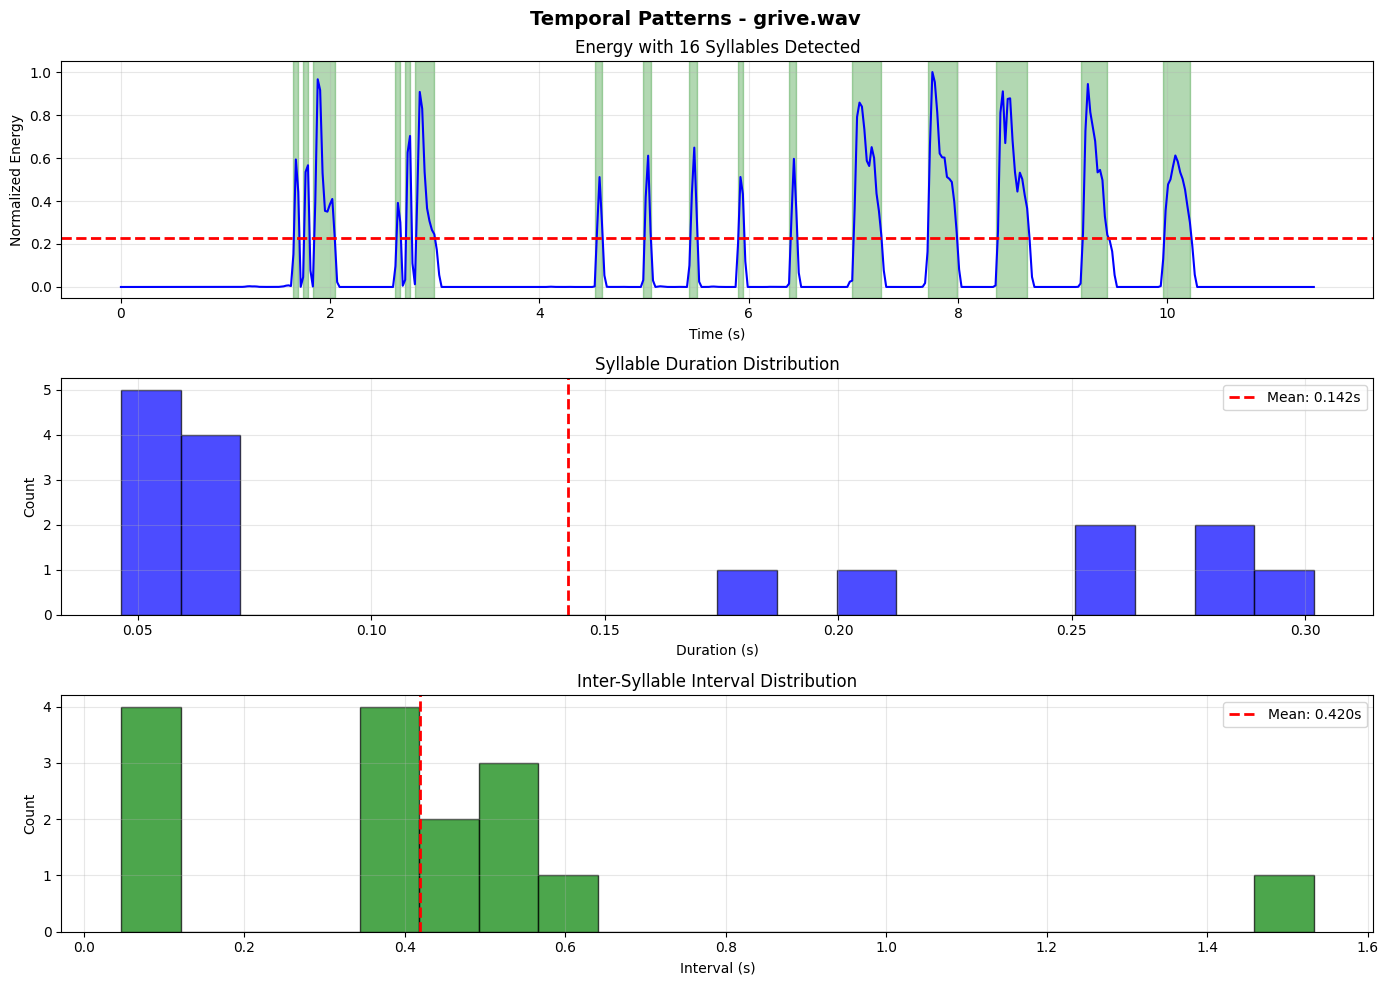

✓ grive.wav: 16 syllables, mean duration=0.142s


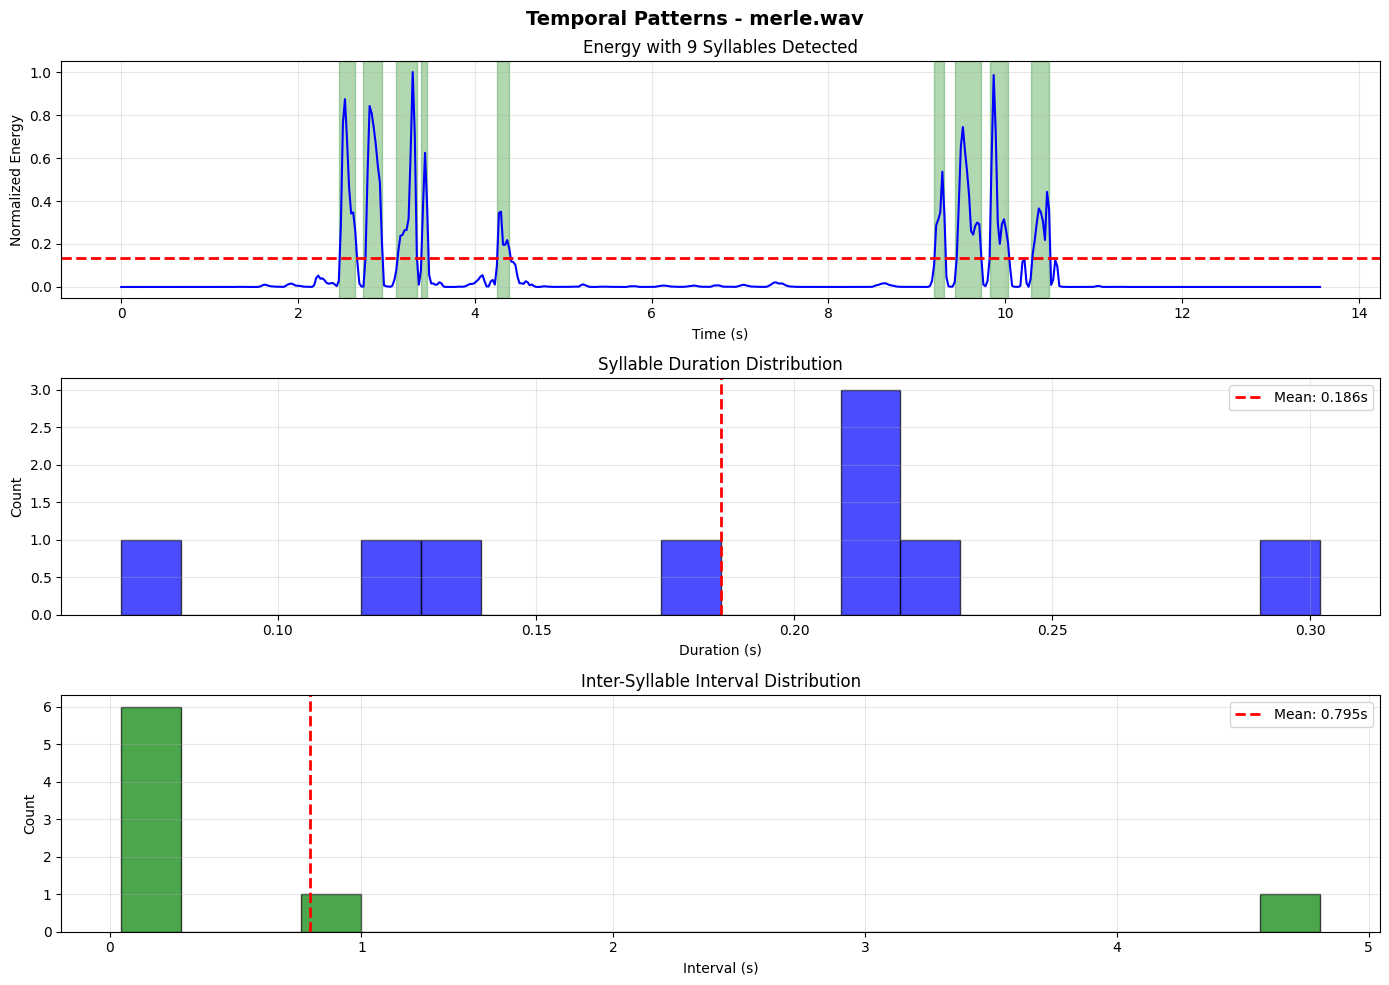

✓ merle.wav: 9 syllables, mean duration=0.186s


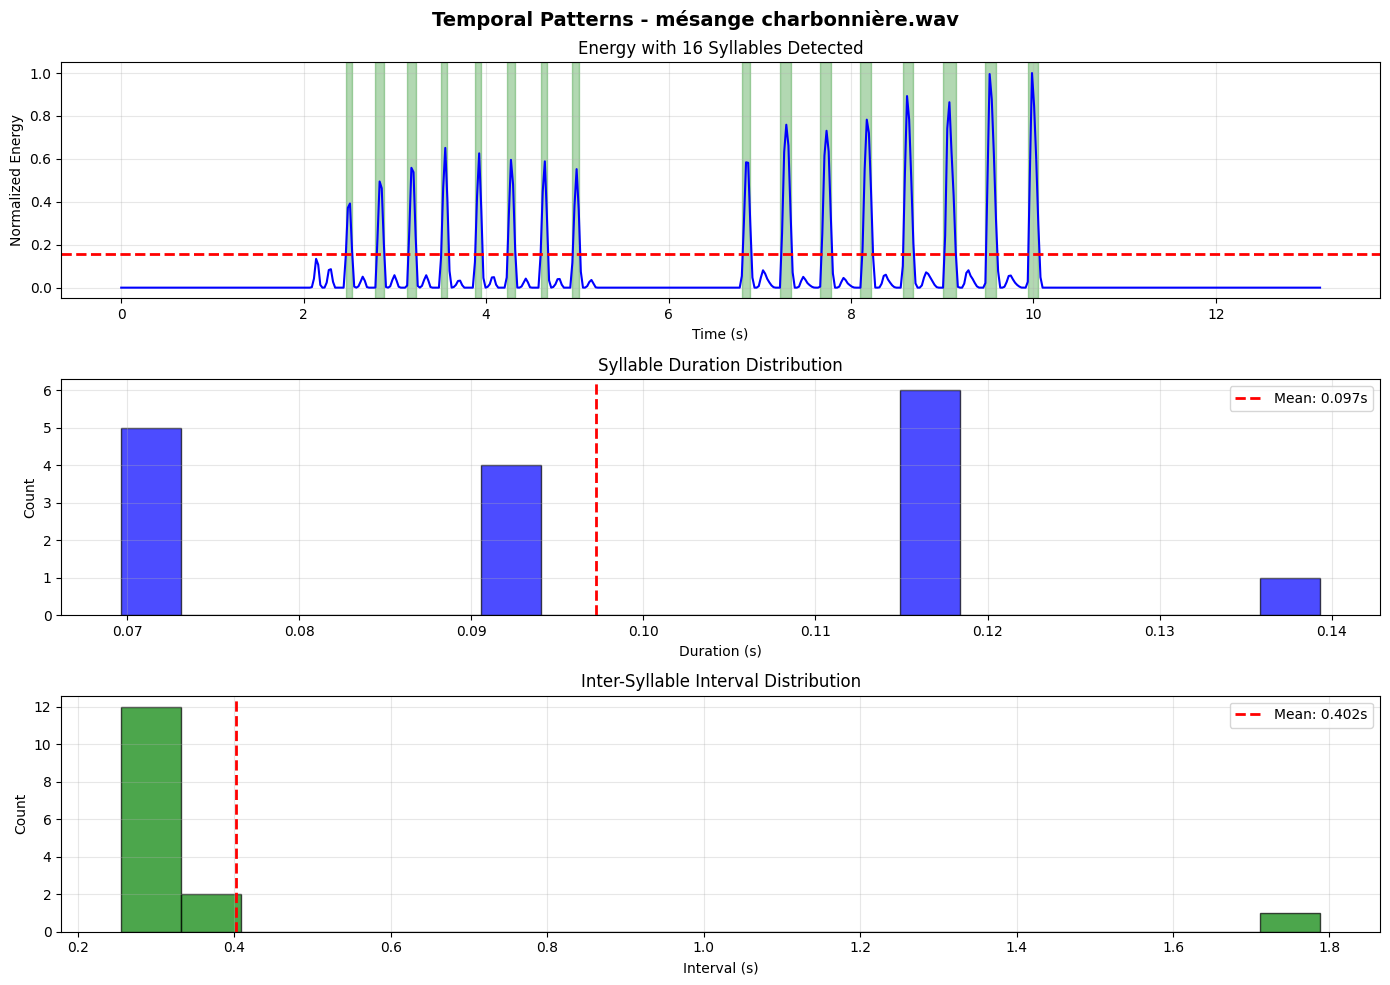

✓ mésange charbonnière.wav: 16 syllables, mean duration=0.097s

TEMPORAL PATTERN SUMMARY:
File                           N_Syll   Dur_Mean     Dur_Std      Int_Mean     Int_Std     
--------------------------------------------------------------------------------------------
grive.wav                      16            0.142s      0.101s      0.420s      0.352s
merle.wav                      9             0.186s      0.065s      0.795s      1.533s
mésange charbonnière.wav       16            0.097s      0.022s      0.402s      0.371s


[{'file': 'grive.wav',
  'n_syllables': 16,
  'durations': [np.float64(0.046439909297052155),
   np.float64(0.046439909297052155),
   np.float64(0.2089795918367347),
   np.float64(0.046439909297052155),
   np.float64(0.046439909297052155),
   np.float64(0.18575963718820862),
   np.float64(0.06965986394557823),
   np.float64(0.06965986394557823),
   np.float64(0.06965986394557823),
   np.float64(0.046439909297052155),
   np.float64(0.06965986394557823),
   np.float64(0.2786394557823129),
   np.float64(0.2786394557823129),
   np.float64(0.301859410430839),
   np.float64(0.25541950113378686),
   np.float64(0.25541950113378686)],
  'intervals': [np.float64(0.046439909297052155),
   np.float64(0.046439909297052155),
   np.float64(0.5804988662131519),
   np.float64(0.046439909297052155),
   np.float64(0.046439909297052155),
   np.float64(1.5325170068027212),
   np.float64(0.3947392290249433),
   np.float64(0.37151927437641724),
   np.float64(0.3947392290249433),
   np.float64(0.4411791383219

In [9]:
def temporal_pattern_analysis(wav_files, folder, fs, lowcut, highcut, N=1200, k=0.8, frame_length=50, hop_length=512):
    """
    Analyze temporal patterns: syllable duration, inter-syllable intervals.
    
    Temporal structure is crucial for:
    - Species identification
    - Individual recognition
    - Song complexity assessment
    """
    print("\n" + "="*80)
    print("TEMPORAL PATTERN ANALYSIS")
    print("="*80)
    
    
    
    all_patterns = []
    
    for bird_idx, filename in enumerate(wav_files[:3]):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        bp_filter = firwin(N + 1, [lowcuts[bird_idx], highcuts[bird_idx]], pass_zero=False, fs=fs, window=window)
        
        # Apply filter
        y_filt = lfilter(bp_filter, 1.0, y)
        
        # Detect syllables
        energy = np.array([
            np.sum(y_filt[i:i+frame_length]**2)
            for i in range(0, len(y_filt)-frame_length, hop_length)
        ])
        energy = energy / (np.max(energy) + 1e-10)
        
        threshold = np.mean(energy) + k * np.std(energy)
        detections = energy > threshold
        
        diff_detect = np.diff(detections.astype(int))
        starts = np.where(diff_detect == 1)[0]
        ends = np.where(diff_detect == -1)[0]
        
        if len(starts) > 0 and len(ends) > 0:
            if ends[0] < starts[0]:
                ends = ends[1:]
            if len(starts) > len(ends):
                starts = starts[:len(ends)]
        
        # Calculate durations and intervals
        durations = []
        intervals = []
        
        for i, (start, end) in enumerate(zip(starts, ends)):
            duration_sec = (end - start) * hop_length / sr
            if duration_sec >= 0.02:  # Minimum 20ms
                durations.append(duration_sec)
                
                if i > 0:
                    interval_sec = (start - ends[i-1]) * hop_length / sr
                    intervals.append(interval_sec)
        
        patterns = {
            'file': filename,
            'n_syllables': len(durations),
            'durations': durations,
            'intervals': intervals,
            'mean_duration': np.mean(durations) if durations else 0,
            'std_duration': np.std(durations) if durations else 0,
            'mean_interval': np.mean(intervals) if intervals else 0,
            'std_interval': np.std(intervals) if intervals else 0
        }
        all_patterns.append(patterns)
        
        # Visualization
        if len(durations) > 0:
            fig, axes = plt.subplots(3, 1, figsize=(14, 10))
            fig.suptitle(f'Temporal Patterns - {filename}', fontsize=14, fontweight='bold')
            
            # Energy with syllable markers
            time_frames = np.arange(len(energy)) * hop_length / sr
            axes[0].plot(time_frames, energy, 'b', linewidth=1.5)
            axes[0].axhline(threshold, color='r', linestyle='--', linewidth=2)
            
            for start, end in zip(starts, ends):
                t_start = start * hop_length / sr
                t_end = end * hop_length / sr
                axes[0].axvspan(t_start, t_end, alpha=0.3, color='green')
            
            axes[0].set_title(f'Energy with {len(durations)} Syllables Detected')
            axes[0].set_xlabel('Time (s)')
            axes[0].set_ylabel('Normalized Energy')
            axes[0].grid(True, alpha=0.3)
            
            # Duration histogram
            axes[1].hist(durations, bins=20, color='blue', alpha=0.7, edgecolor='black')
            axes[1].axvline(np.mean(durations), color='r', linestyle='--', 
                          linewidth=2, label=f'Mean: {np.mean(durations):.3f}s')
            axes[1].set_title(f'Syllable Duration Distribution')
            axes[1].set_xlabel('Duration (s)')
            axes[1].set_ylabel('Count')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            # Interval histogram
            if len(intervals) > 0:
                axes[2].hist(intervals, bins=20, color='green', alpha=0.7, edgecolor='black')
                axes[2].axvline(np.mean(intervals), color='r', linestyle='--', 
                              linewidth=2, label=f'Mean: {np.mean(intervals):.3f}s')
                axes[2].set_title(f'Inter-Syllable Interval Distribution')
                axes[2].set_xlabel('Interval (s)')
                axes[2].set_ylabel('Count')
                axes[2].legend()
                axes[2].grid(True, alpha=0.3)
            else:
                axes[2].text(0.5, 0.5, 'Insufficient syllables for interval analysis',
                           ha='center', va='center', transform=axes[2].transAxes)
            
            plt.tight_layout()
            plt.savefig(f'temporal_patterns_{filename[:-4]}.png', dpi=150, bbox_inches='tight')
            plt.show()
        
        print(f"✓ {filename}: {len(durations)} syllables, "
              f"mean duration={np.mean(durations) if durations else 0:.3f}s")
    
    # Summary table
    print("\n" + "="*80)
    print("TEMPORAL PATTERN SUMMARY:")
    print("="*80)
    print(f"{'File':<30} {'N_Syll':<8} {'Dur_Mean':<12} {'Dur_Std':<12} "
          f"{'Int_Mean':<12} {'Int_Std':<12}")
    print("-"*92)
    for p in all_patterns:
        print(f"{p['file']:<30} {p['n_syllables']:<8} "
              f"{p['mean_duration']:>10.3f}s {p['std_duration']:>10.3f}s "
              f"{p['mean_interval']:>10.3f}s {p['std_interval']:>10.3f}s")
    
    return all_patterns

temporal_pattern_analysis(wav_files, folder, fs, lowcut, highcut, N=N, k=0.5, frame_length=2048, hop_length=1024   )

## 2.3 Analyse des Syllabes sur tous les fichiers

In [10]:
def syllable_counting(wav_files, folder, fs, lowcut, highcut, N=1200):
    """
    Count syllables in bird songs using energy-based segmentation.
    
    Algorithm:
    1. Apply bandpass filter
    2. Compute short-term energy
    3. Apply threshold to detect syllables
    4. Remove very short detections (likely noise)
    5. Count remaining segments as syllables
    """

    print("\n" + "=" * 80)
    print("STEP 4: SYLLABLE ANALYSIS")
    print("=" * 80)

    # Bandpass filter
    bp_filter = firwin(N + 1, [lowcut, highcut], pass_zero=False, fs=fs)

    results = []

    # Processing each file
    for filename in wav_files:
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)

        # Filter
        y_filt = lfilter(bp_filter, 1.0, y)

        # Compute short-term energy
        frame_length = 2048
        hop_length = 512
        energy = np.array([
            np.sum(y_filt[i:i+frame_length]**2)
            for i in range(0, len(y_filt)-frame_length, hop_length)
        ])
        energy /= (np.max(energy) + 1e-10)

        # Adaptive threshold
        k = 2.0
        threshold = np.mean(energy) + k * np.std(energy)

        # Binarize energy above threshold
        detections = energy > threshold

        # Find rising (start) and falling (end) edges
        diff = np.diff(detections.astype(int))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]

        # Fix boundary mismatch
        if len(ends) > 0 and len(starts) > 0:
            if ends[0] < starts[0]:
                ends = ends[1:]
            if len(starts) > len(ends):
                starts = starts[:len(ends)]

        # Minimum syllable duration filtering
        min_duration_sec = 0.05
        min_frames = int(min_duration_sec * sr / hop_length)

        valid_syllables = []
        for s, e in zip(starts, ends):
            if (e - s) >= min_frames:
                valid_syllables.append((s, e))

        syllable_count = len(valid_syllables)
        duration_sec = len(y) / sr

        results.append({
            'file': filename,
            'n_syllables': syllable_count,
            'duration': duration_sec,
            'syllables_per_sec': syllable_count / duration_sec,
            'segments': valid_syllables,
        })

        # Visualization for each file
        fig, axes = plt.subplots(2, 1, figsize=(14, 7))
        fig.suptitle(f"Syllable Detection – {filename}", fontsize=14, fontweight='bold')

        # Waveform with highlighted syllables
        time = np.arange(len(y_filt)) / sr
        axes[0].plot(time, y_filt, 'b', linewidth=0.7)
        for s, e in valid_syllables:
            axes[0].axvspan(s * hop_length / sr,
                            e * hop_length / sr,
                            alpha=0.3, color='green')
        axes[0].set_title(f"Filtered Waveform – {syllable_count} syllables detected")
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Amplitude")
        axes[0].grid(True, alpha=0.3)

        # Energy plot
        frame_times = np.arange(len(energy)) * hop_length / sr
        axes[1].plot(frame_times, energy, 'b', label="Energy")
        axes[1].axhline(threshold, color='r', linestyle='--', linewidth=2,
                        label=f"Threshold")
        for s, e in valid_syllables:
            axes[1].axvspan(s * hop_length / sr,
                            e * hop_length / sr,
                            alpha=0.3, color='green')

        axes[1].set_title("Energy & Threshold")
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylabel("Normalized Energy")
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        plt.tight_layout()
        plt.savefig(f"syllables_{filename[:-4]}.png", dpi=150, bbox_inches='tight')
        plt.close()

        print(f"✓ {filename}: {syllable_count} syllables "
              f"({syllable_count / duration_sec:.2f} syll/sec)")

    # ===========================
    # GLOBAL SUMMARY
    # ===========================
    print("\n" + "="*70)
    print("SYLLABLE ANALYSIS SUMMARY (ALL FILES)")
    print("="*70)
    print(f"{'File':30s} | {'Count':>6s} | {'Duration(s)':>12s} | {'Syll/sec':>8s}")
    print("-"*70)

    for r in results:
        print(f"{r['file']:30s} | {r['n_syllables']:6d} | "
              f"{r['duration']:12.2f} | {r['syllables_per_sec']:8.2f}")

    print("="*70)

    return results

syllable_counting(wav_files, folder, fs, lowcut, highcut, N=N)


STEP 4: SYLLABLE ANALYSIS
✓ grive.wav: 8 syllables (0.70 syll/sec)
✓ merle.wav: 6 syllables (0.44 syll/sec)
✓ mésange charbonnière.wav: 13 syllables (0.98 syll/sec)
✓ pic vert.wav: 15 syllables (1.15 syll/sec)
✓ pie.wav: 10 syllables (0.71 syll/sec)
✓ pigeon.wav: 5 syllables (0.39 syll/sec)
✓ pinson.wav: 13 syllables (0.91 syll/sec)
✓ rouge-gorge.wav: 9 syllables (0.69 syll/sec)
✓ sitelle torchepot.wav: 10 syllables (0.69 syll/sec)
✓ tourterelle.wav: 10 syllables (0.75 syll/sec)

SYLLABLE ANALYSIS SUMMARY (ALL FILES)
File                           |  Count |  Duration(s) | Syll/sec
----------------------------------------------------------------------
grive.wav                      |      8 |        11.46 |     0.70
merle.wav                      |      6 |        13.62 |     0.44
mésange charbonnière.wav       |     13 |        13.20 |     0.98
pic vert.wav                   |     15 |        13.10 |     1.15
pie.wav                        |     10 |        14.06 |     0.71
pigeon.wa

[{'file': 'grive.wav',
  'n_syllables': 8,
  'duration': 11.459047619047618,
  'syllables_per_sec': 0.6981382978723405,
  'segments': [(np.int64(160), np.int64(165)),
   (np.int64(244), np.int64(249)),
   (np.int64(605), np.int64(614)),
   (np.int64(616), np.int64(620)),
   (np.int64(665), np.int64(678)),
   (np.int64(723), np.int64(735)),
   (np.int64(793), np.int64(803)),
   (np.int64(866), np.int64(870))]},
 {'file': 'merle.wav',
  'n_syllables': 6,
  'duration': 13.618503401360543,
  'syllables_per_sec': 0.44057704603580566,
  'segments': [(np.int64(214), np.int64(222)),
   (np.int64(239), np.int64(252)),
   (np.int64(280), np.int64(287)),
   (np.int64(293), np.int64(298)),
   (np.int64(815), np.int64(826)),
   (np.int64(847), np.int64(853))]},
 {'file': 'mésange charbonnière.wav',
  'n_syllables': 13,
  'duration': 13.200544217687074,
  'syllables_per_sec': 0.984807882585752,
  'segments': [(np.int64(272), np.int64(276)),
   (np.int64(303), np.int64(307)),
   (np.int64(335), np.in

## 3. Spectrogramme

Ce module réalise une analyse temps–fréquence avancée en comparant deux approches complémentaires : la STFT (Short-Time Fourier Transform) et la transformée en ondelettes continues (CWT). L’objectif est d’évaluer comment différentes résolutions temporelles et fréquentielles permettent d’observer la structure du chant d’oiseaux, souvent composé d’unités brèves, modulées, et très variables dans le temps.

La première partie étudie la STFT avec différents jeux de paramètres. La STFT consiste à appliquer une FFT sur des fenêtres successives du signal : la taille de la fenêtre (n_fft) conditionne la résolution fréquentielle, et le pas de calcul (hop_length) conditionne la résolution temporelle. L’utilisateur teste donc trois configurations contrastées :

une configuration privilégiant la résolution temporelle (petit n_fft), utile pour observer des syllabes très rapides ;

une configuration équilibrée, un compromis entre finesse temporelle et précision en fréquence ;

une configuration favorisant la résolution fréquentielle (grand n_fft), permettant d’observer clairement les harmoniques ou modulations lentes.
Ces variations permettent de montrer que la STFT impose un compromis fixe : améliorer l'une des résolutions dégrade l’autre.

La seconde partie applique une transformée en ondelettes continues (CWT), qui offre une alternative à la STFT grâce à sa résolution variable. Avec l’ondelette de Morlet — particulièrement adaptée aux signaux oscillatoires comme les vocalisations d’oiseaux — les hautes fréquences sont analysées avec une bonne précision temporelle, tandis que les basses fréquences bénéficient d’une meilleure précision fréquentielle. Contrairement à la STFT, la CWT ne se limite pas à une grille temps–fréquence régulière : elle permet d’observer plus finement les modulations, les glissandi et les structures transitoires du chant. Les échelles choisies (scales = 1..128) déterminent les bandes fréquentielles analysées, tandis que la conversion en fréquences est assurée par PyWavelets.

Enfin, l’ensemble du processus s’appuie sur le signal préfiltré, afin de concentrer l’analyse dans la bande utile propre à chaque espèce et de réduire l’influence du bruit. Les visualisations générées permettent une comparaison directe : d’un côté, les spectrogrammes STFT montrant l’impact du choix de n_fft, de l’autre la représentation en ondelettes révélant une vision multi-échelle plus riche. Ce module constitue donc un outil essentiel pour déterminer quelle méthode temps–fréquence est la plus adaptée selon le type de vocalisation étudiée (très brève, harmonique, modulée, continue, etc.).


STEP 2: TIME-FREQUENCY ANALYSIS


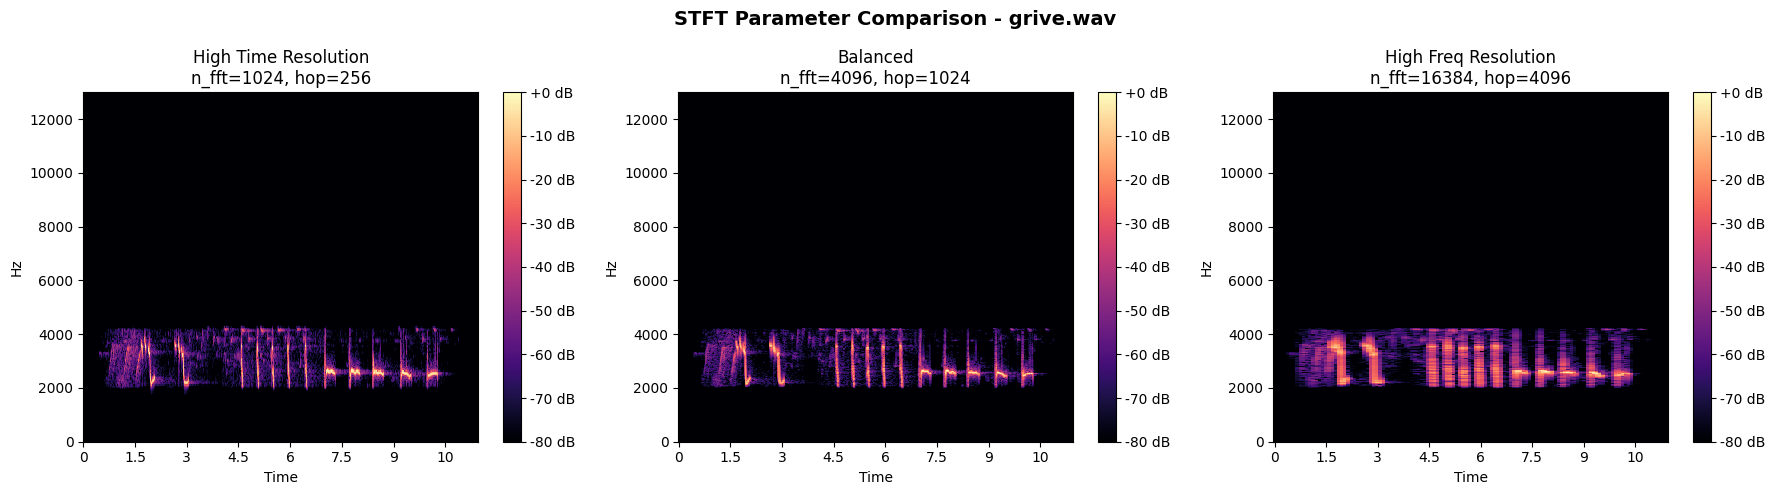

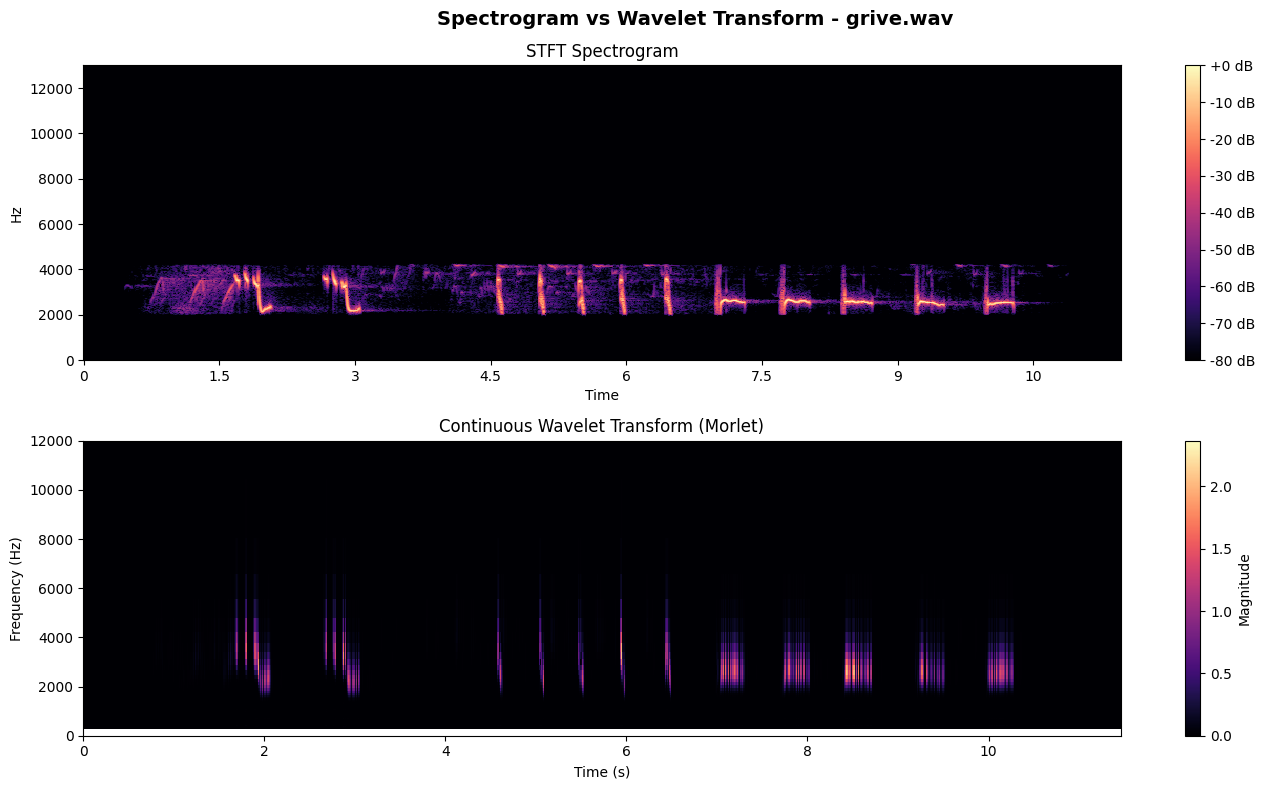

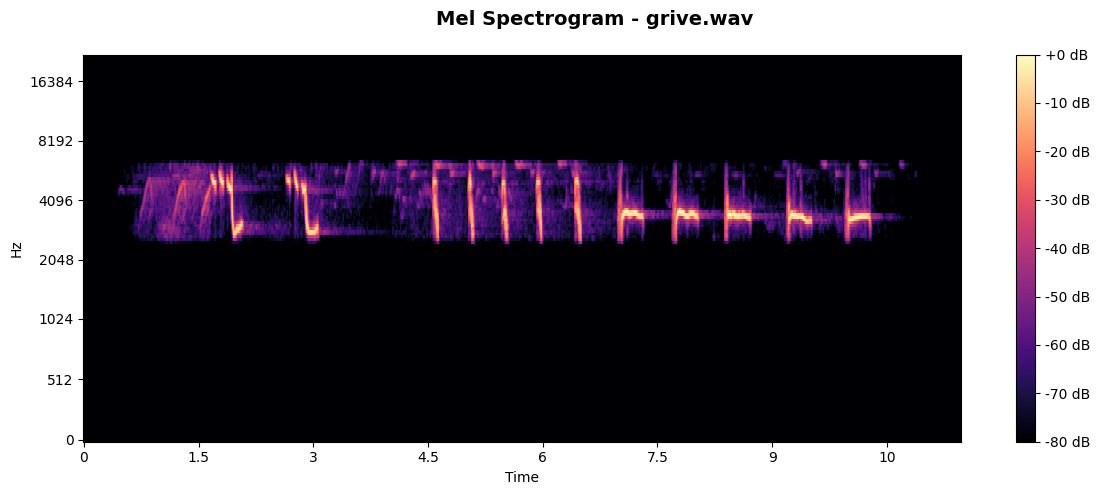

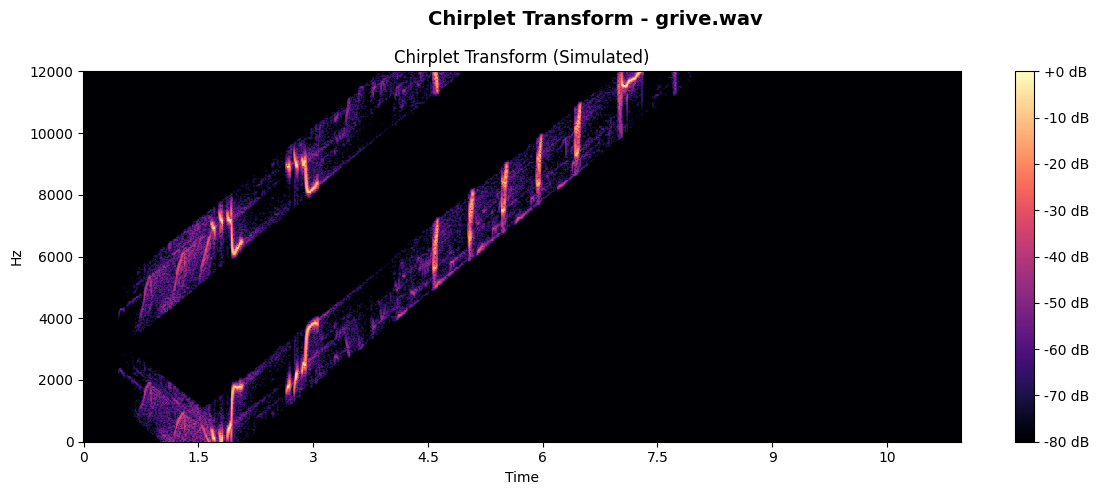

✓ Completed time-frequency analysis for grive.wav


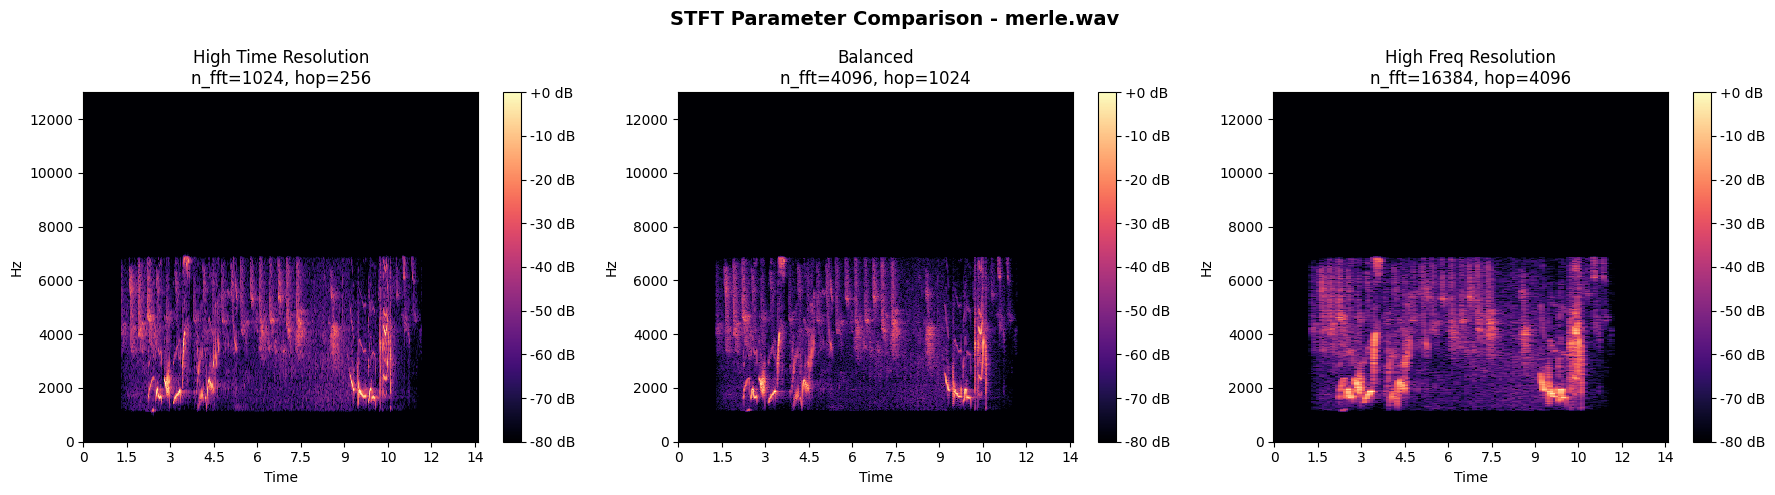

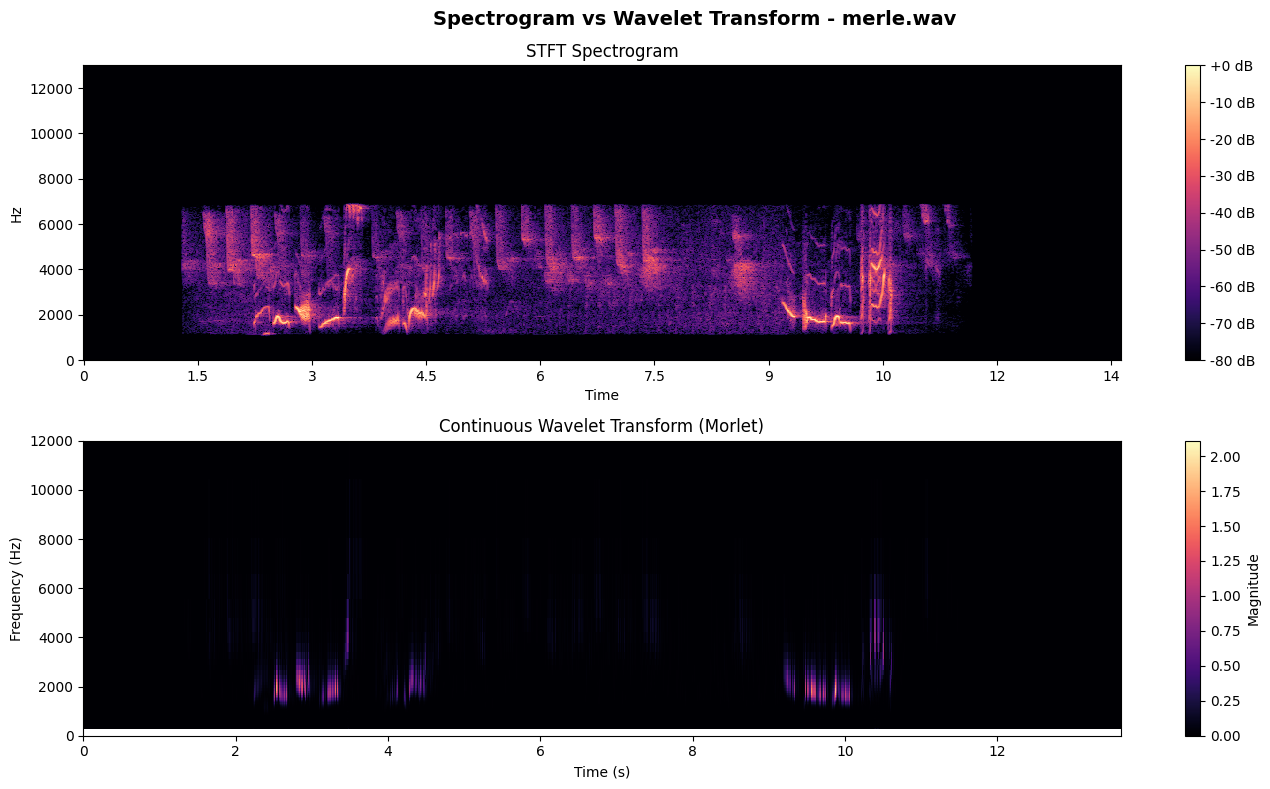

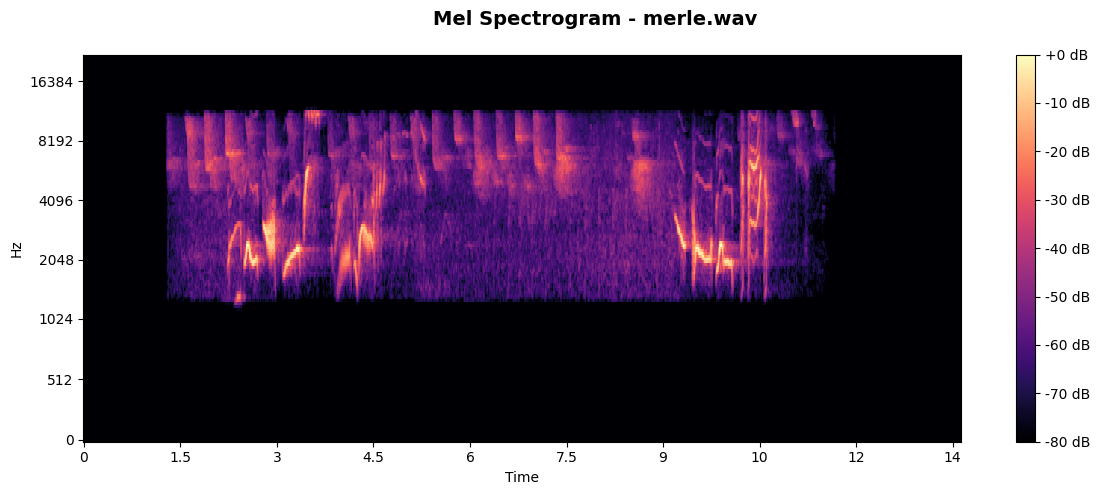

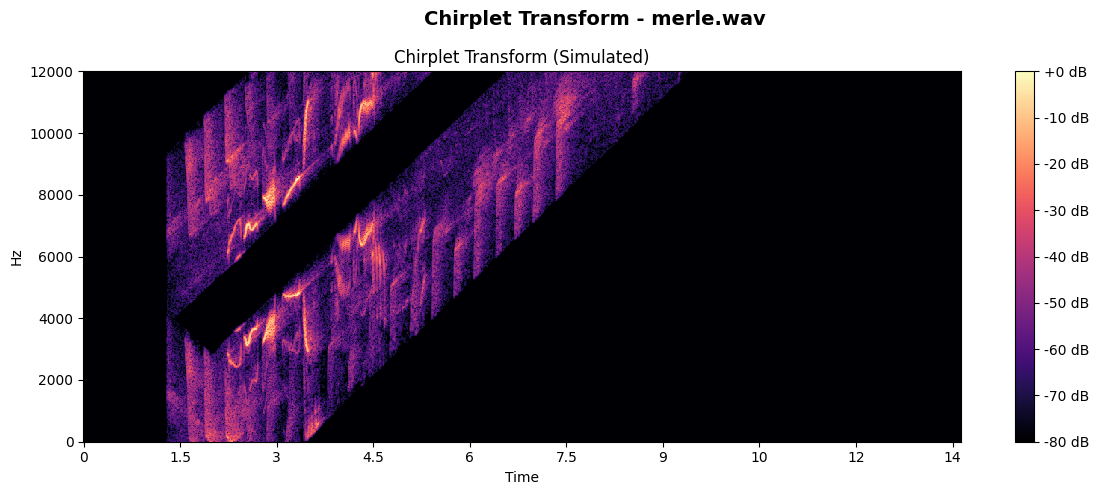

✓ Completed time-frequency analysis for merle.wav


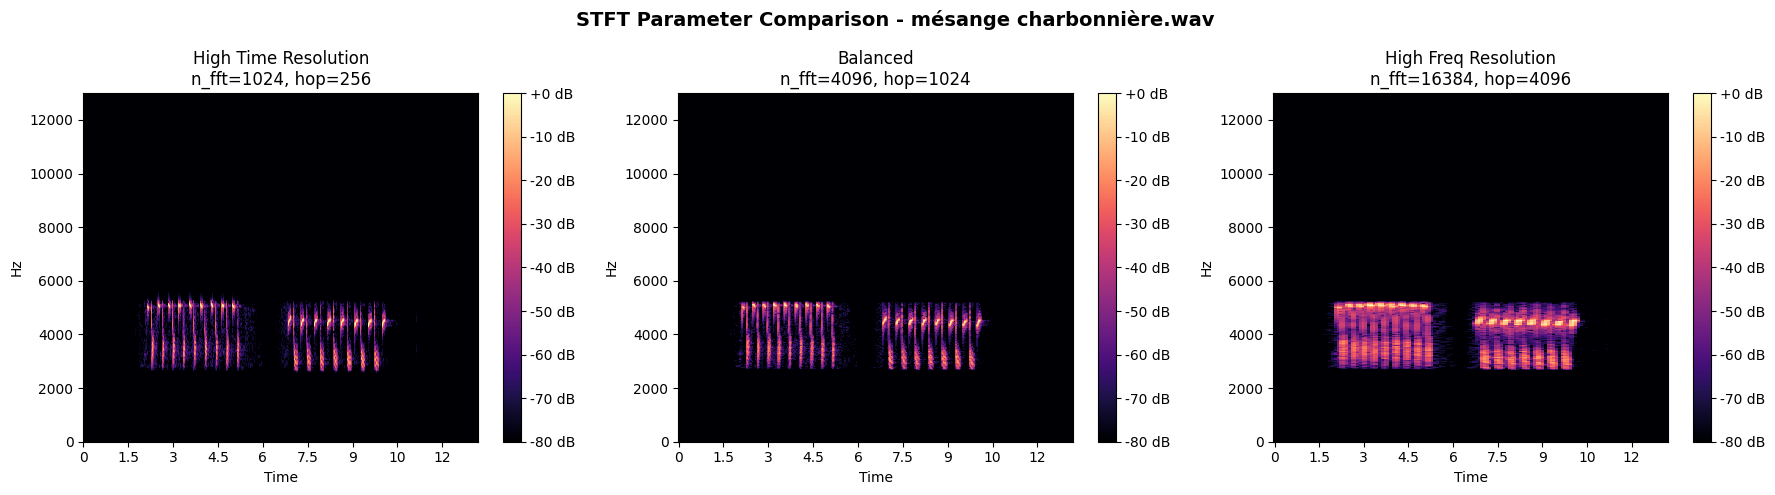

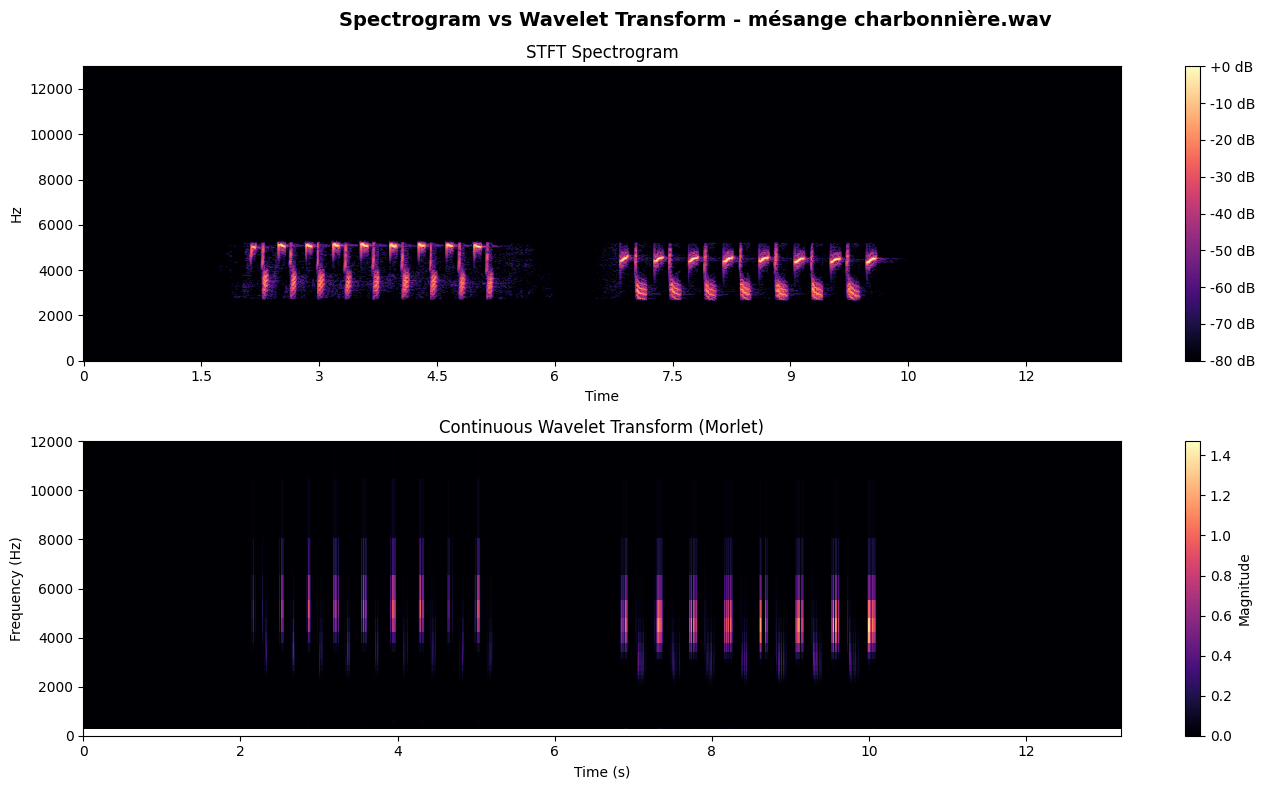

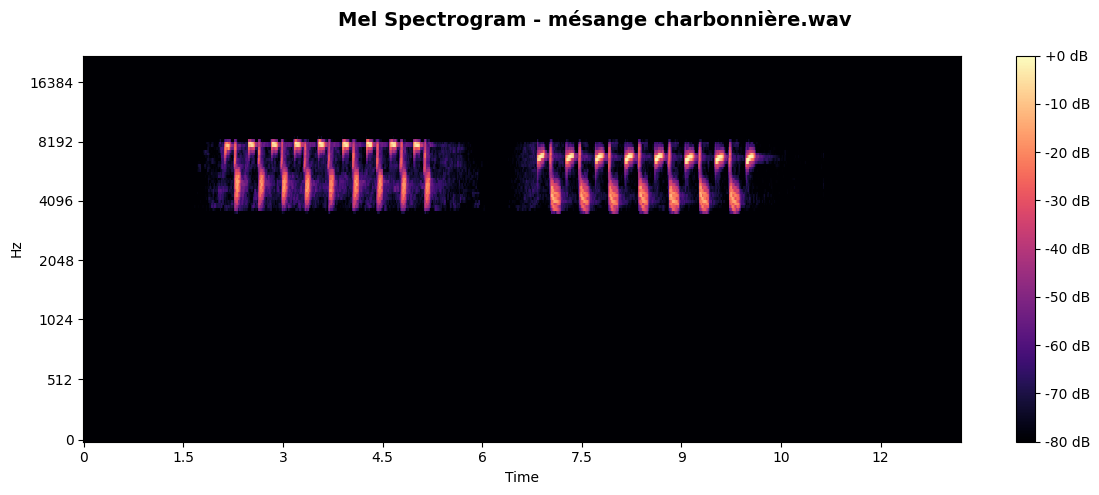

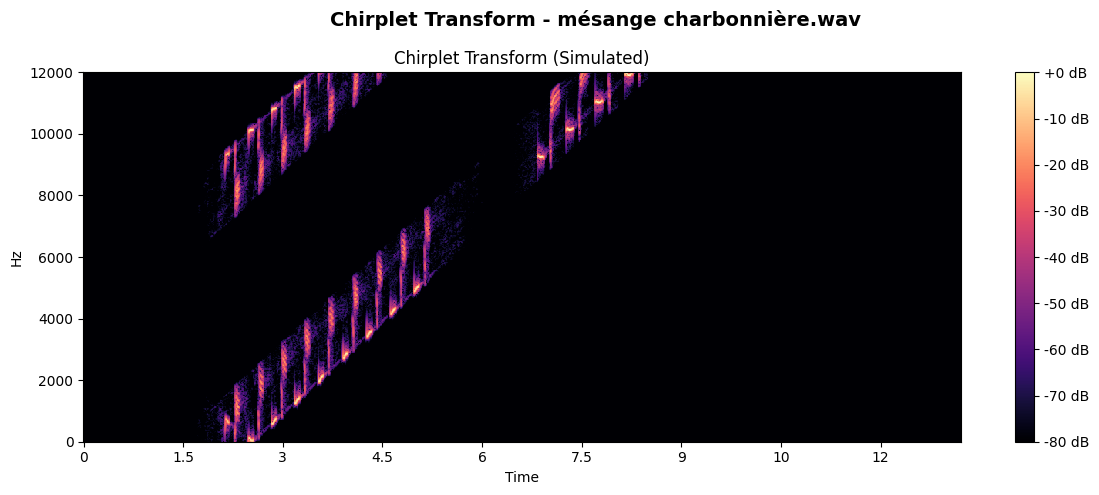

✓ Completed time-frequency analysis for mésange charbonnière.wav


In [ ]:
def time_frequency_analysis(wav_files, folder, fs, lowcut, highcut, N=1200):
    """
    Compare STFT (Spectrogram) with different parameters and Wavelet Transform.
    
    STFT Parameters:
    - n_fft: FFT window size (frequency resolution)
    - hop_length: overlap between windows (time resolution)
    - window: window function type
    
    Wavelet Parameters:
    - Scales: determine frequency range
    - Wavelet type: 'morl' (Morlet) good for audio
    """
    print("\n" + "=" * 80)
    print("STEP 2: TIME-FREQUENCY ANALYSIS")
    print("=" * 80)
    
    
    # STFT parameter sets
    stft_params = [
        {'n_fft': 1024, 'hop_length': 256, 'name': 'High Time Resolution'},
        {'n_fft': 4096, 'hop_length': 1024, 'name': 'Balanced'},
        {'n_fft': 16384, 'hop_length': 4096, 'name': 'High Freq Resolution'}
    ]
    
    selected_files = wav_files[:3]
    
    for bird_idx, filename in enumerate(wav_files[:3]):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        bp_filter = firwin(N + 1, [lowcuts[bird_idx], highcuts[bird_idx]], pass_zero=False, fs=fs, window=window)
        
        # Apply filter
        y_filt = lfilter(bp_filter, 1.0, y)
        
        
        # ===== STEP 2.2: STFT with different parameters =====
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'STFT Parameter Comparison - {filename}', 
                    fontsize=14, fontweight='bold')
        
        for idx, params in enumerate(stft_params):
            D = librosa.stft(y_filt, n_fft=params['n_fft'], 
                           hop_length=params['hop_length'])
            S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            
            img = librosa.display.specshow(S_dB, sr=sr, 
                                          hop_length=params['hop_length'],
                                          x_axis='time', y_axis='hz', 
                                          cmap='magma', ax=axes[idx])
            axes[idx].set_title(f"{params['name']}\n"
                              f"n_fft={params['n_fft']}, hop={params['hop_length']}")
            axes[idx].set_ylim([0, highcut + 1000])
            fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')
        
        plt.tight_layout()
        plt.savefig(f'stft_comparison_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # ===== STEP 2.3: WAVELET ANALYSIS =====
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        fig.suptitle(f'Spectrogram vs Wavelet Transform - {filename}', 
                    fontsize=14, fontweight='bold')
        
        # Spectrogram
        D = librosa.stft(y_filt, n_fft=4096, hop_length=1024)
        S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img1 = librosa.display.specshow(S_dB, sr=sr, hop_length=512,
                                       x_axis='time', y_axis='hz', 
                                       cmap='magma', ax=axes[0])
        axes[0].set_title('STFT Spectrogram')
        axes[0].set_ylim([0, highcut + 1000])
        fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
        
        # Continuous Wavelet Transform
        # Select subset for computational efficiency
        max_duration = 16.0  # secondes
        max_samples = int(max_duration * sr)

        y_subset = y_filt[:max_samples]
        time_cwt = np.arange(len(y_subset)) / sr
            
        scales = np.arange(1, 128)
        coefficients, frequencies = pywt.cwt(y_subset, scales, 'morl', 1/sr)
        
        time_cwt = np.arange(len(y_subset)) / sr
        img2 = axes[1].pcolormesh(time_cwt, frequencies, np.abs(coefficients), 
                                  cmap='magma', shading='auto')
        axes[1].set_title('Continuous Wavelet Transform (Morlet)')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Frequency (Hz)')
        axes[1].set_ylim([0, highcut])
        fig.colorbar(img2, ax=axes[1], label='Magnitude')
        
        plt.tight_layout()
        plt.savefig(f'wavelet_analysis_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        

        # ===== STEP 2.4: MEL SPECTROGRAM =====
        fig, ax = plt.subplots(figsize=(12, 5))
        fig.suptitle(f'Mel Spectrogram - {filename}',
                     fontsize=14, fontweight='bold')

        S_mel = librosa.feature.melspectrogram(
            y=y_filt, 
            sr=sr, 
            n_fft=2048, 
            hop_length=512,
            n_mels=128,
            fmin=lowcut,
            fmax=highcut
        )
        
        S_mel_dB = librosa.power_to_db(S_mel, ref=np.max)

        img = librosa.display.specshow(
            S_mel_dB,
            sr=sr,
            hop_length=512,
            x_axis='time',
            y_axis='mel',
            cmap='magma',
            ax=ax
        )

        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(f'mel_spectrogram_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()


        # ===== STEP 2.5: CHIRPLET TRANSFORM =====
        fig, ax = plt.subplots(figsize=(12, 5))
        fig.suptitle(f'Chirplet Transform - {filename}',
                     fontsize=14, fontweight='bold')

        # Chirplet modulation sweep
        t = np.arange(len(y_filt)) / sr
        chirp_rate = 2000   # sweep speed (modifiable)
        
        y_chirp_real = np.real(y_filt * np.exp(1j * np.pi * chirp_rate * t**2))
        # STFT of chirp-modulated signal
        D_chirp = librosa.stft(y_chirp_real, n_fft=2048, hop_length=512)
        S_chirp = np.abs(D_chirp)
        
        

        img = librosa.display.specshow(
            librosa.amplitude_to_db(S_chirp, ref=np.max),
            sr=sr,
            hop_length=512,
            x_axis='time',
            y_axis='hz',
            cmap='magma',
            ax=ax
        )

        ax.set_ylim([0, highcut])
        ax.set_title('Chirplet Transform (Simulated)')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(f'chirplet_transform_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✓ Completed time-frequency analysis for {filename}")


time_frequency_analysis(wav_files, folder, fs, lowcut, highcut, N=N)

## 3.2 Spectrogrammes Mel et Chirplet 

Ce module effectue une analyse temps–fréquence avancée en utilisant deux représentations spécialisées : le spectrogramme Mel et la transformée chirplet. L’objectif est de capturer des aspects du chant des oiseaux qui ne sont pas toujours visibles dans un simple spectrogramme linéaire ou une STFT classique, en mettant en évidence à la fois le contenu spectral perceptuel et les modulations fréquentielles rapides.

La première partie calcule le spectrogramme Mel, qui projette l’énergie spectrale sur une échelle de fréquences perceptuelle inspirée de l’audition humaine. Cette représentation est particulièrement utile pour analyser le timbre et la distribution énergétique des vocalisations sur des bandes de fréquences non linéaires. Les paramètres essentiels incluent le nombre de bandes (n_mels), la taille de la fenêtre FFT (n_fft), le pas de fenêtre (hop_length), ainsi que les fréquences minimale et maximale (fmin et fmax) correspondant à la bande utile pour les vocalisations étudiées. La conversion en dB permet de visualiser clairement les variations d’énergie sur le temps et de comparer l’intensité relative des différents composants fréquentiels.

La seconde partie simule une transformée chirplet, qui est une généralisation de la STFT incluant un balayage fréquentiel linéaire (chirp) dans le temps. Cette approche est adaptée pour détecter des modulations rapides et des glissandi, caractéristiques fréquentes dans les chants d’oiseaux. Dans ce code, l’implémentation est simulée en multipliant le signal par un terme complexe exponentiel modulé (exp(j π chirp_rate t²)), puis en calculant une STFT sur le signal modulé. Le résultat met en évidence la variation instantanée de la fréquence dans le temps, offrant une vision multi-échelle des glissandi et des transitions rapides que la STFT classique peut lisser ou manquer.

Les visualisations générées — spectrogrammes Mel et chirplet — permettent de comparer la répartition énergétique perceptuelle et la dynamique fréquentielle instantanée. Ces représentations sont particulièrement utiles pour distinguer des espèces ou des individus par des motifs de modulation caractéristiques, analyser la complexité du chant, ou détecter des éléments transitoires subtils qui seraient masqués dans un spectrogramme classique.



STEP 2.2 : MEL & CHIRPLET SPECTROGRAM ANALYSIS


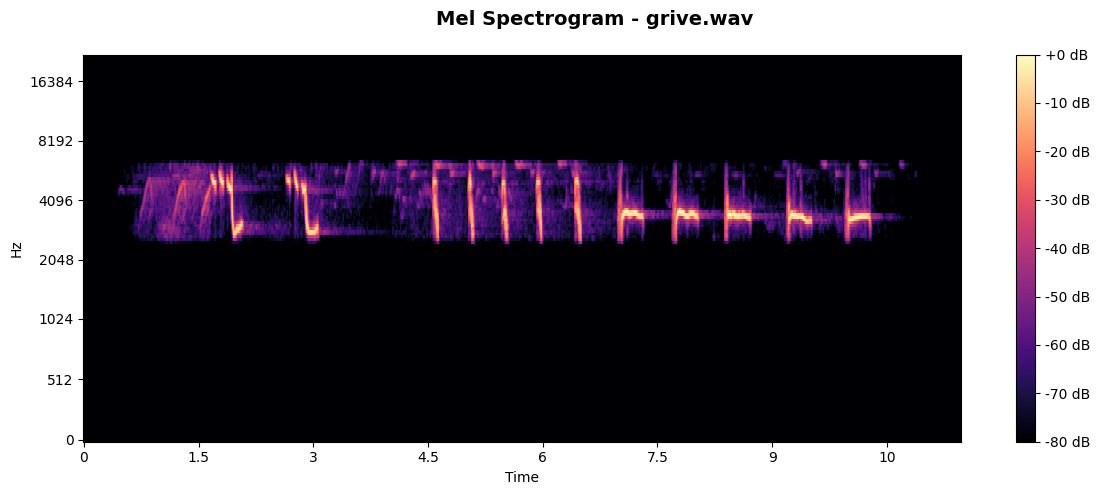

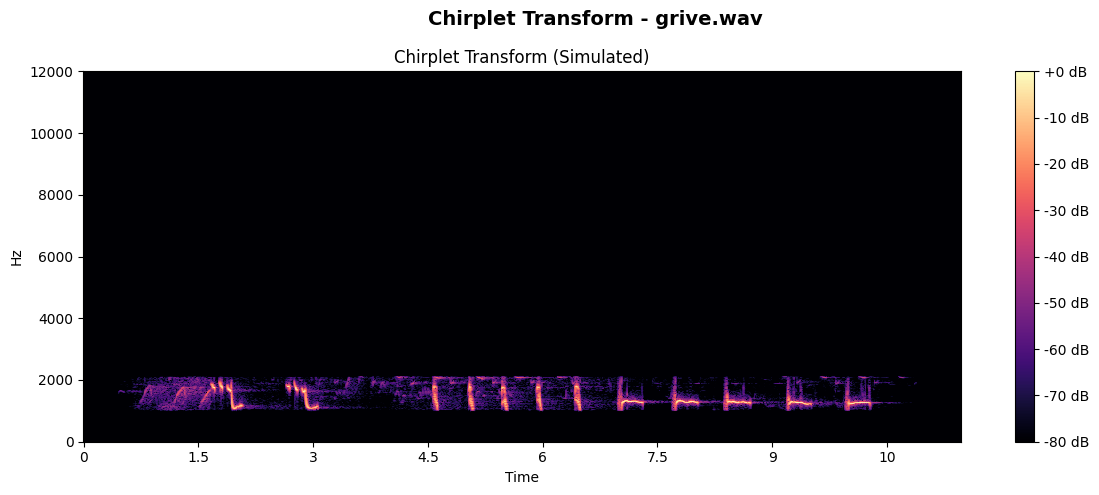

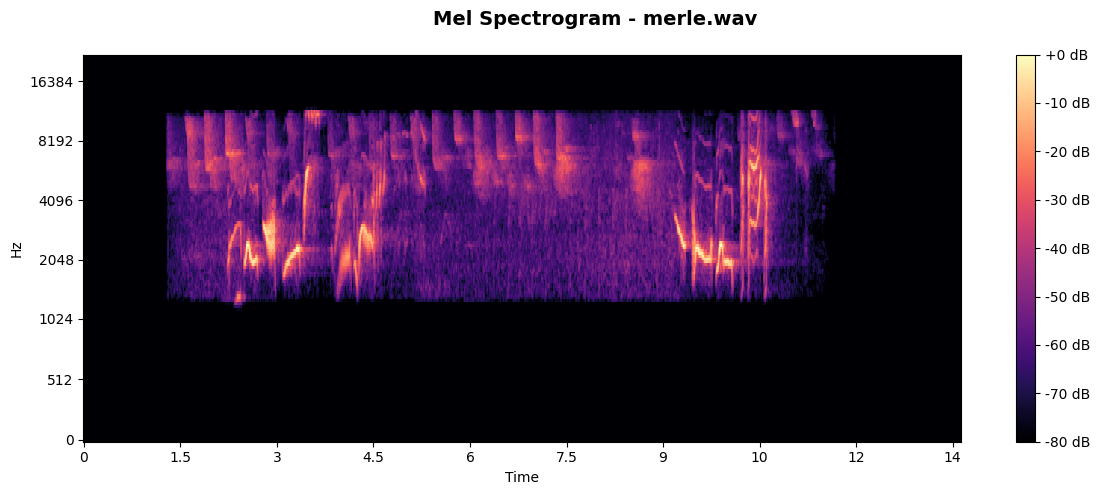

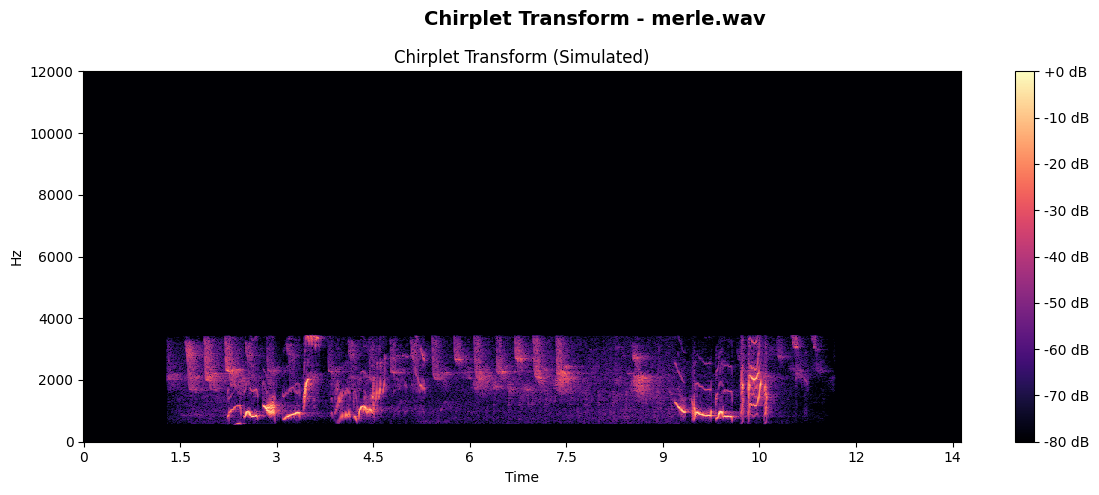

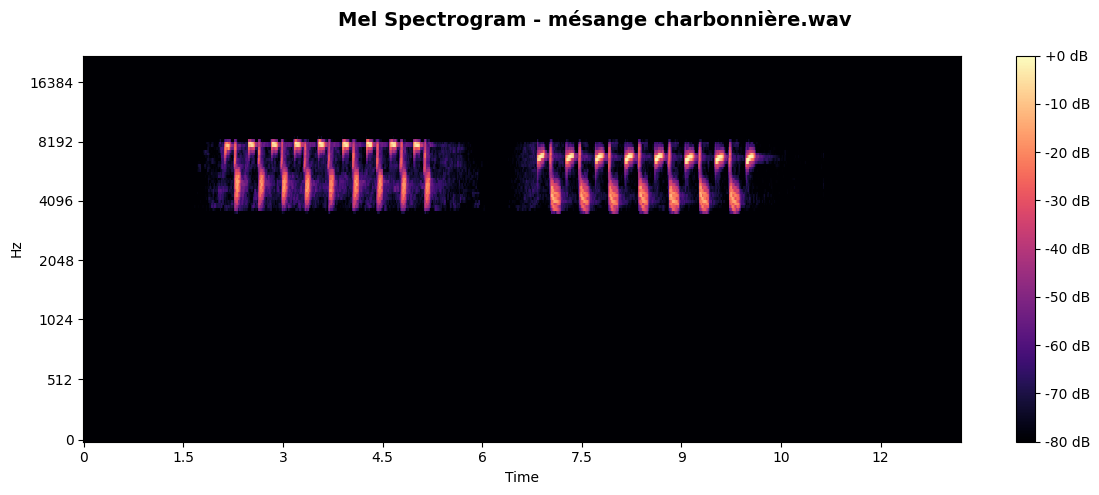

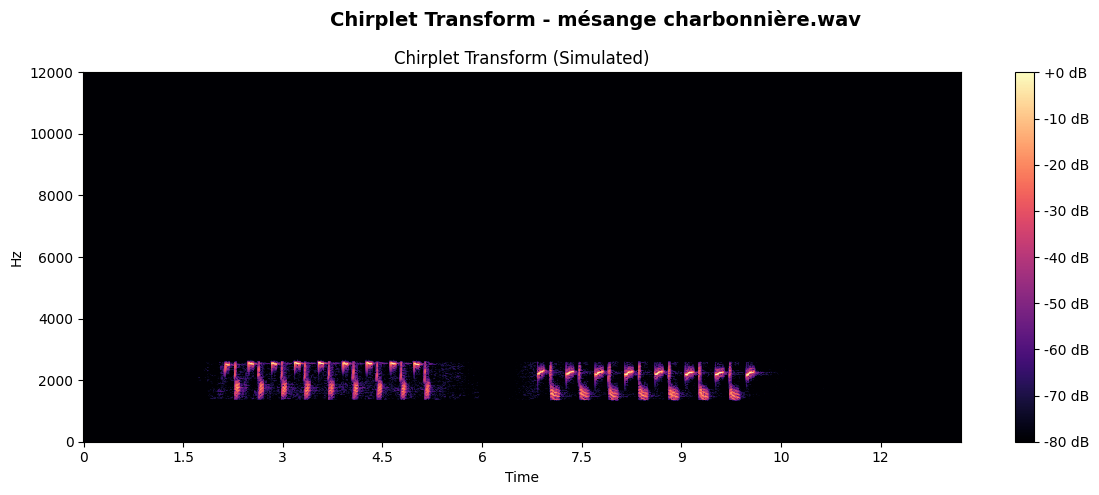

In [12]:
import scipy.signal
from scipy.signal import stft
def mel_chirplet_spectrogram_analysis(wav_files, folder, fs, lowcut, highcut, N=1200):
 
    
    print("\n" + "=" * 80)
    print("STEP 2.2 : MEL & CHIRPLET SPECTROGRAM ANALYSIS")
    print("=" * 80)
    
    
    # STFT parameter sets
    stft_params = [
        {'n_fft': 1024, 'hop_length': 256, 'name': 'High Time Resolution'},
        {'n_fft': 4096, 'hop_length': 1024, 'name': 'Balanced'},
        {'n_fft': 16384, 'hop_length': 4096, 'name': 'High Freq Resolution'}
    ]
    
    selected_files = wav_files[:3]
    
    for bird_idx, filename in enumerate(wav_files[:3]):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        bp_filter = firwin(N + 1, [lowcuts[bird_idx], highcuts[bird_idx]], pass_zero=False, fs=fs, window=window)
        
        # Apply filter
        y_filt = lfilter(bp_filter, 1.0, y)        


        # ===== STEP 2.4: MEL SPECTROGRAM =====
        fig, ax = plt.subplots(figsize=(12, 5))
        fig.suptitle(f'Mel Spectrogram - {filename}',
                     fontsize=14, fontweight='bold')

        S_mel = librosa.feature.melspectrogram(
            y=y_filt, 
            sr=sr, 
            n_fft=2048, 
            hop_length=512,
            n_mels=128,
            fmin=lowcut,
            fmax=highcut
        )
        
        S_mel_dB = librosa.power_to_db(S_mel, ref=np.max)

        img = librosa.display.specshow(
            S_mel_dB,
            sr=sr,
            hop_length=512,
            x_axis='time',
            y_axis='mel',
            cmap='magma',
            ax=ax
        )

        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(f'mel_spectrogram_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()


        # ===== STEP 2.5: CHIRPLET TRANSFORM =====
        fig, ax = plt.subplots(figsize=(12, 5))
        fig.suptitle(f'Chirplet Transform - {filename}',
                     fontsize=14, fontweight='bold')

        # Chirplet modulation sweep
        t = np.arange(len(y_filt)) / sr
        chirp_rate = 2000   # sweep speed (modifiable)
        
        f, t_seg, Zxx = stft(y_filt * np.exp(1j * np.pi * chirp_rate * np.arange(len(y_filt))/sr**2), 
                     fs=sr, nperseg=2048, noverlap=1536)
        S_chirp = np.abs(Zxx)

        img = librosa.display.specshow(
            librosa.amplitude_to_db(S_chirp, ref=np.max),
            sr=sr,
            hop_length=512,
            x_axis='time',
            y_axis='hz',
            cmap='magma',
            ax=ax
        )

        ax.set_ylim([0, highcut])
        ax.set_title('Chirplet Transform (Simulated)')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(f'chirplet_transform_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()

mel_chirplet_spectrogram_analysis(wav_files, folder, fs, lowcut, highcut, N=N)

## 3.3 Analyse du timbre (pitch)

Ce module réalise une analyse du contour de hauteur fondamentale (F0) des chants d’oiseaux, c’est-à-dire la variation de la fréquence fondamentale dans le temps. L’analyse de F0 est cruciale pour identifier les modulations fréquentielles, les motifs mélodiques, et permet de différencier espèces ou individus sur la base de la structure tonale de leurs vocalisations.

Le code commence par appliquer un filtrage passe-bande FIR sur le signal audio pour isoler la bande fréquentielle pertinente et réduire l’influence du bruit. La fréquence fondamentale est ensuite extraite à l’aide de l’algorithme pyin de Librosa, une version probabiliste du YIN, adaptée aux signaux monophoniques et bruyants. Cet algorithme fournit à la fois la valeur estimée de F0, un indicateur de trame voisé/non voisé et la probabilité associée à chaque trame, permettant de distinguer les parties actives du chant des silences ou bruits parasites.

Les visualisations combinent plusieurs perspectives : le signal temporel filtré, le spectrogramme avec le contour de F0 superposé, et le contour de F0 seul, où les trames voisé sont mises en évidence. Cela permet de voir comment la fréquence fondamentale évolue sur le temps et comment elle correspond aux transitoires spectrales. Des statistiques sont également calculées : moyenne, étendue et écart-type de F0, ainsi que le pourcentage de trames voisé, fournissant des indicateurs quantitatifs sur la tonalité et la constance du chant.




PITCH CONTOUR ANALYSIS

grive.wav:
  Mean F0: 1463.9 Hz
  F0 Range: 633.1 - 2093.0 Hz
  F0 Std Dev: 352.7 Hz
  Voiced frames: 822/988 (83.2%)


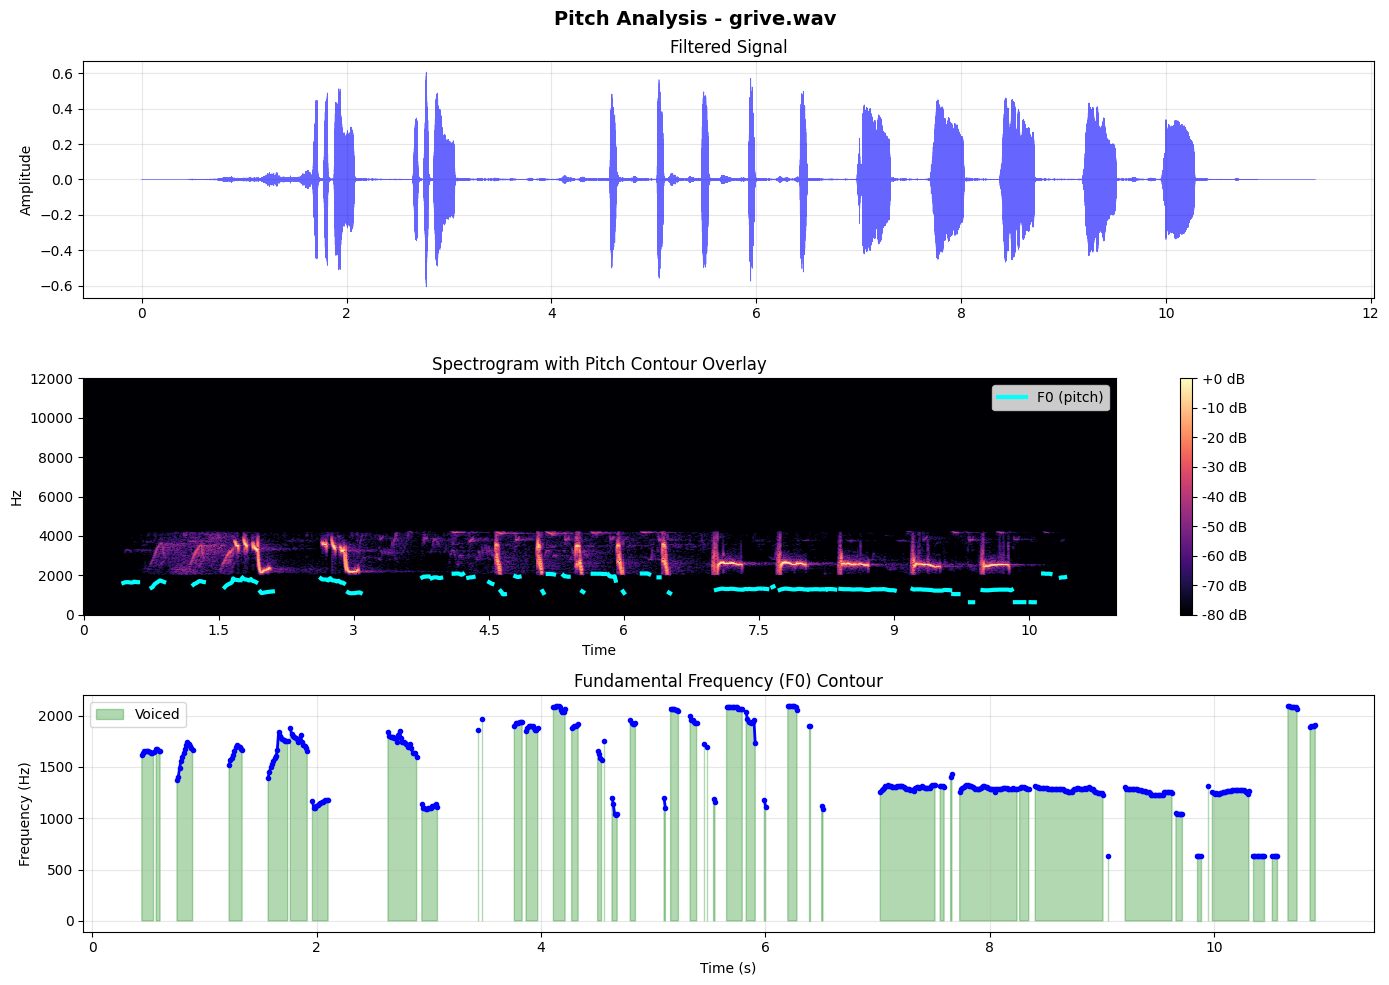


merle.wav:
  Mean F0: 980.2 Hz
  F0 Range: 580.6 - 1975.5 Hz
  F0 Std Dev: 237.5 Hz
  Voiced frames: 446/1174 (38.0%)


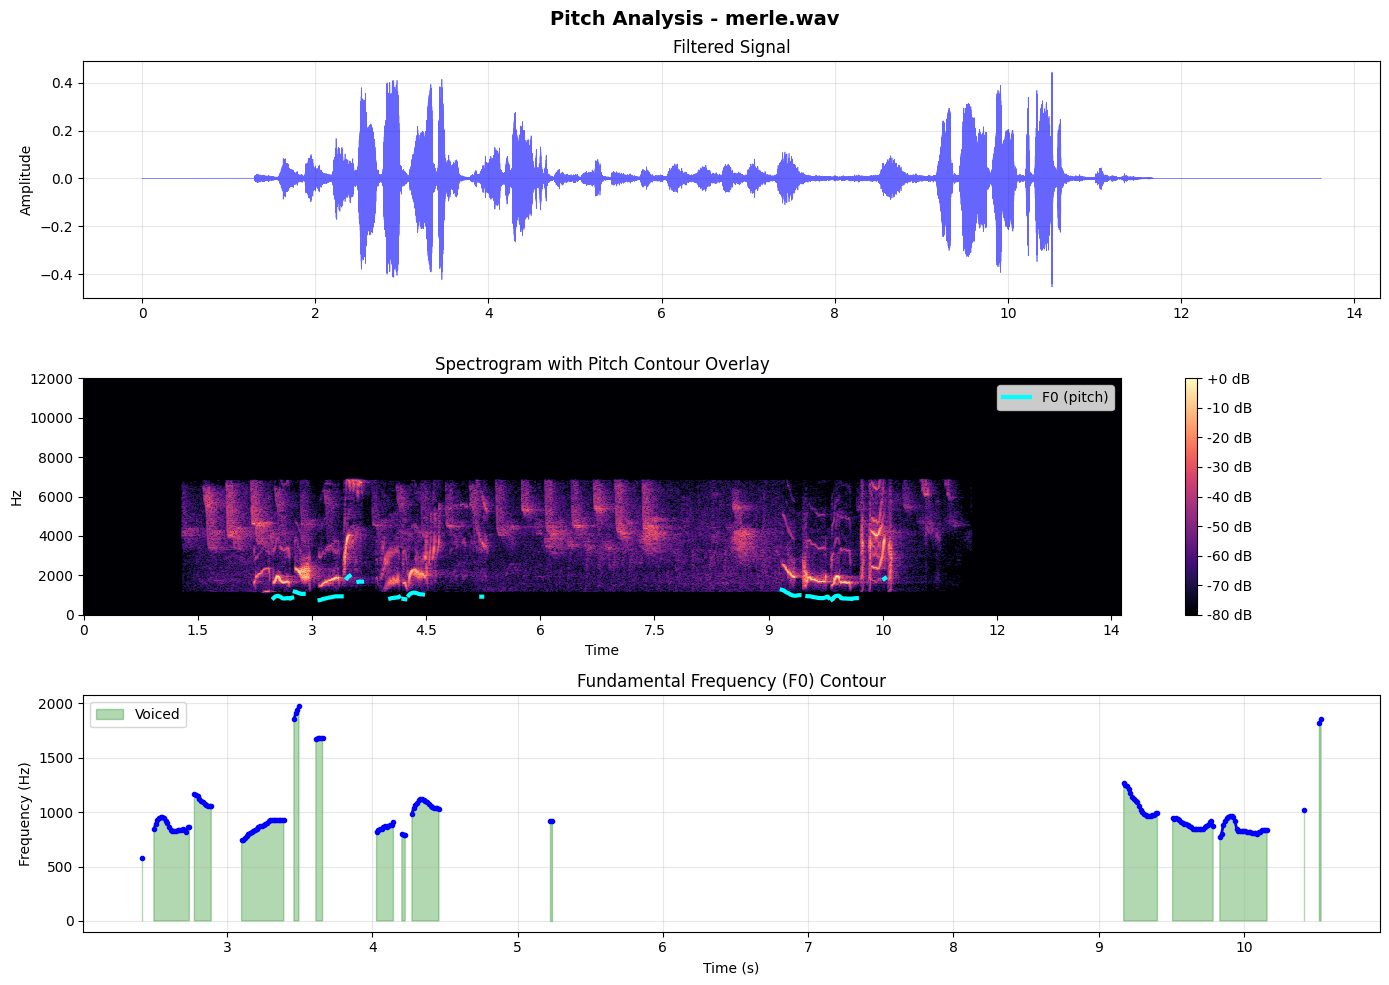


mésange charbonnière.wav:
  Mean F0: 1432.7 Hz
  F0 Range: 854.9 - 1832.6 Hz
  F0 Std Dev: 200.3 Hz
  Voiced frames: 581/1138 (51.1%)


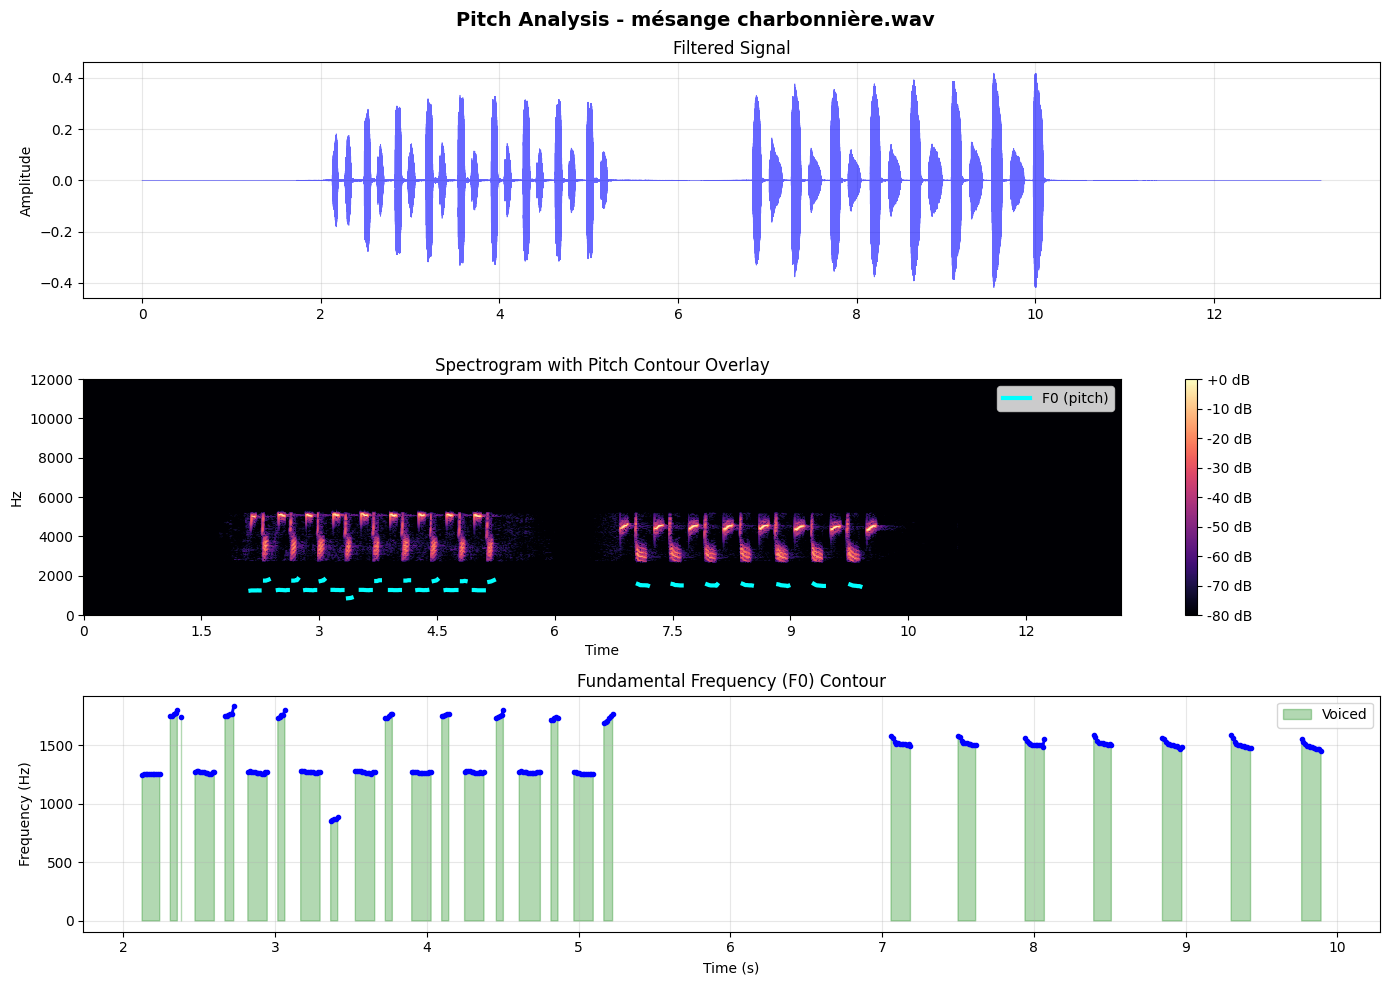

In [18]:
def pitch_contour_analysis(wav_files, folder, fs,  N=1200):
    """
    Analyze pitch contours (fundamental frequency over time).
    
    Uses librosa's pyin algorithm (probabilistic YIN).
    Important for:
    - Identifying frequency modulation patterns
    - Analyzing melodic structure
    - Species identification
    """
    print("\n" + "="*80)
    print("PITCH CONTOUR ANALYSIS")
    print("="*80)
    
    for bird_idx, filename in enumerate(wav_files[:3]):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        bp_filter = firwin(N + 1, [lowcuts[bird_idx], highcuts[bird_idx]], pass_zero=False, fs=fs, window=window)
        
        # Apply filter
        y_filt = lfilter(bp_filter, 1.0, y)
        
        # Extract pitch using pyin
        f0, voiced_flag, voiced_probs = librosa.pyin(
            y_filt, 
            fmin=librosa.note_to_hz('C2'),  # ~65 Hz
            fmax=librosa.note_to_hz('C7')   # ~2093 Hz
        )
        voicing_threshold = 0.4  # essayer 0.7 → 0.9
        f0_clean = f0.copy()
        f0_clean[voiced_probs < voicing_threshold] = np.nan
        
        # Create visualization
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        fig.suptitle(f'Pitch Analysis - {filename}', fontsize=14, fontweight='bold')
        
        # Waveform
        times = np.arange(len(y_filt)) / sr
        axes[0].plot(times, y_filt, 'b', alpha=0.6, linewidth=0.5)
        axes[0].set_title('Filtered Signal')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)
        
        # Spectrogram with pitch overlay
        D = librosa.stft(y_filt, n_fft=2048, hop_length=512)
        S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(S_dB, sr=sr, hop_length=512,
                                      x_axis='time', y_axis='hz', 
                                      cmap='magma', ax=axes[1])
        
        # Overlay pitch contour
        times_f0 = librosa.times_like(f0_clean, sr=sr, hop_length=512)
        axes[1].plot(times_f0, f0_clean, 'cyan', linewidth=3, label='F0 (pitch)')
        axes[1].set_ylim([0, highcut])
        axes[1].set_title('Spectrogram with Pitch Contour Overlay')
        axes[1].legend(loc='upper right')
        fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
        
        # Pitch contour alone
        axes[2].plot(times_f0, f0_clean, 'b', linewidth=2, marker='o', markersize=3)
        axes[2].fill_between(times_f0, 0, f0_clean, where=voiced_flag, 
                            alpha=0.3, color='green', label='Voiced')
        axes[2].set_title('Fundamental Frequency (F0) Contour')
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Frequency (Hz)')
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        # Statistics
        f0_valid = f0_clean[~np.isnan(f0_clean)]
        if len(f0_valid) > 0:
            print(f"\n{filename}:")
            print(f"  Mean F0: {np.mean(f0_valid):.1f} Hz")
            print(f"  F0 Range: {np.min(f0_valid):.1f} - {np.max(f0_valid):.1f} Hz")
            print(f"  F0 Std Dev: {np.std(f0_valid):.1f} Hz")
            print(f"  Voiced frames: {np.sum(voiced_flag)}/{len(voiced_flag)} "
                  f"({100*np.sum(voiced_flag)/len(voiced_flag):.1f}%)")
        
        plt.tight_layout()
        plt.savefig(f'pitch_contour_{bird_idx+1}.png', dpi=150, bbox_inches='tight')
        plt.show()

pitch_contour_analysis(wav_files, folder, fs, N=N)

## 5. Extraction d'autres caractéristiques avancées spectrales


Ce module extrait un jeu de descripteurs spectraux avancés destinés à caractériser le timbre et la structure fréquentielle des chants d’oiseaux à l’échelle locale (par trame). Les caractéristiques calculées par trame sont ensuite synthétisées par des statistiques (moyenne, écart-type) pour obtenir des signatures exploitables par des classifieurs ou pour des comparaisons inter-fichiers.

Les principales mesures et leur interprétation :

- Spectral Centroid : centre de masse du spectre d’une trame — indicateur de « brillance » ; un centroid plus élevé signifie que l’énergie est concentrée vers les hautes fréquences.

- Spectral Rolloff : fréquence en dessous de laquelle se trouve un pourcentage fixe (par défaut 85%) de l’énergie spectrale ; utile pour séparer signaux à énergie concentrée en basses fréquences d’autres plus « étendus ».

- Spectral Bandwidth : variance pondérée autour du centroid — mesure de la largeur fréquentielle effective du contenu (largeur de bande perceptuelle).

- Zero Crossing Rate (ZCR) : nombre de changements de signe par fenêtre, corrélé à la rugosité temporelle et aux composantes transitoires (utile pour distinguer vocalisations pures vs bruit).

- MFCCs (Mel-Frequency Cepstral Coefficients) : représentation compacte du timbre basée sur une échelle Mel perceptuelle ; les n_mfcc coefficients (ici 13) capturent l’enveloppe spectrale log-mél et sont standards pour la reconnaissance audio.

Points importants d’implémentation et paramètres à surveiller :

Les features sont extraites sur le signal filtré (y_filt) — cela réduit le bruit hors-bande et rend les caractéristiques plus spécifiques aux vocalisations d’intérêt. Le filtre FIR utilise l’ordre N et les coupures pré-calculées ; le choix de N et des coupures influence la fidélité temporelle et la bande utile (un filtre trop agressif peut déformer les transitoires et donc ZCR/MFCC).

Fenêtrage temporel implicite : librosa.feature.* calcule les caractéristiques par trames (frame length / hop length). Les durées de trame déterminent la résolution temps/fréquence : trames longues → meilleure résolution fréquentielle, trames courtes → meilleure résolution temporelle. Adapter ces valeurs selon la durée moyenne des syllabes.

Paramètres des fonctions : spectral_rolloff utilise un pourcentage (par défaut 0.85) — on peut le modifier si l’on veut capter plus ou moins d’énergie pour le rolloff. Pour les MFCC, le nombre de coefficients (n_mfcc) change la représentation.

Normalisation et agrégation : les séries temporelles de centroid, rolloff, bandwidth et ZCR sont ensuite moyennées/écart-typées ; les MFCCs sont réduits par moyenne sur le temps pour obtenir un vecteur fixe par fichier (ici mfcc_mean). Ces choix conditionnent fortement la comparabilité inter-fichiers et la performance en classification.

Limites et robustesse : ZCR est sensible au bruit haute fréquence ; MFCCs sont robustes pour le timbre mais perdent la localisation fréquentielle fine ; rolloff et centroid peuvent être faussés si des sons parasites restent dans la bande passante. Il est souvent utile de normaliser ou d’appliquer un seuillage sur l’énergie avant extraction pour ignorer les trames silencieuses.

Visualisation : le code trace l’évolution temporelle de chaque feature (centroid, rolloff, bandwidth, ZCR) pour examiner la dynamique locale, et affiche les MFCCs en image (specshow) pour repérer motifs temporels et harmoniques. Ces visualisations aident à valider la pertinence des features et à diagnostiquer artefacts (détection d’interférences, trames silencieuses, etc.).

En résumé, ces descripteurs offrent un compromis entre information perceptuelle (MFCC + centroid/rolloff) et mesures simples mais discriminantes (bandwidth, ZCR), et deviennent exploitables après choix soigné des paramètres de fenêtrage, du filtrage préalable et de la normalisation temporelle.


ADVANCED SPECTRAL FEATURE EXTRACTION


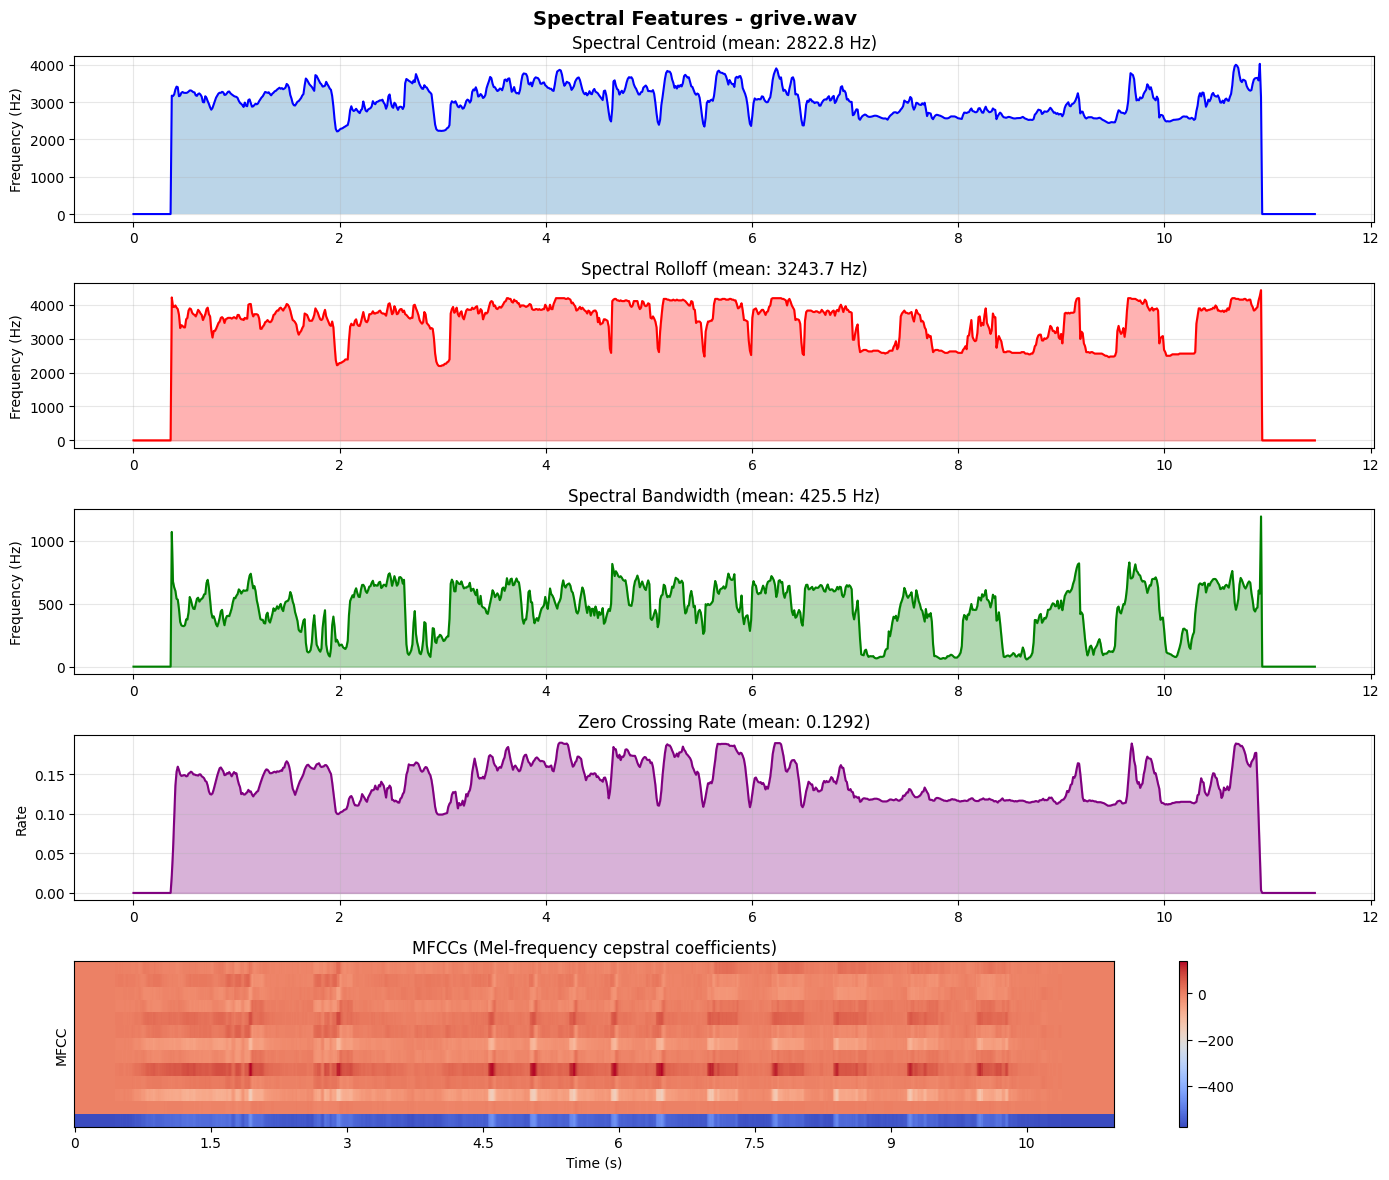

✓ Extracted features from grive.wav


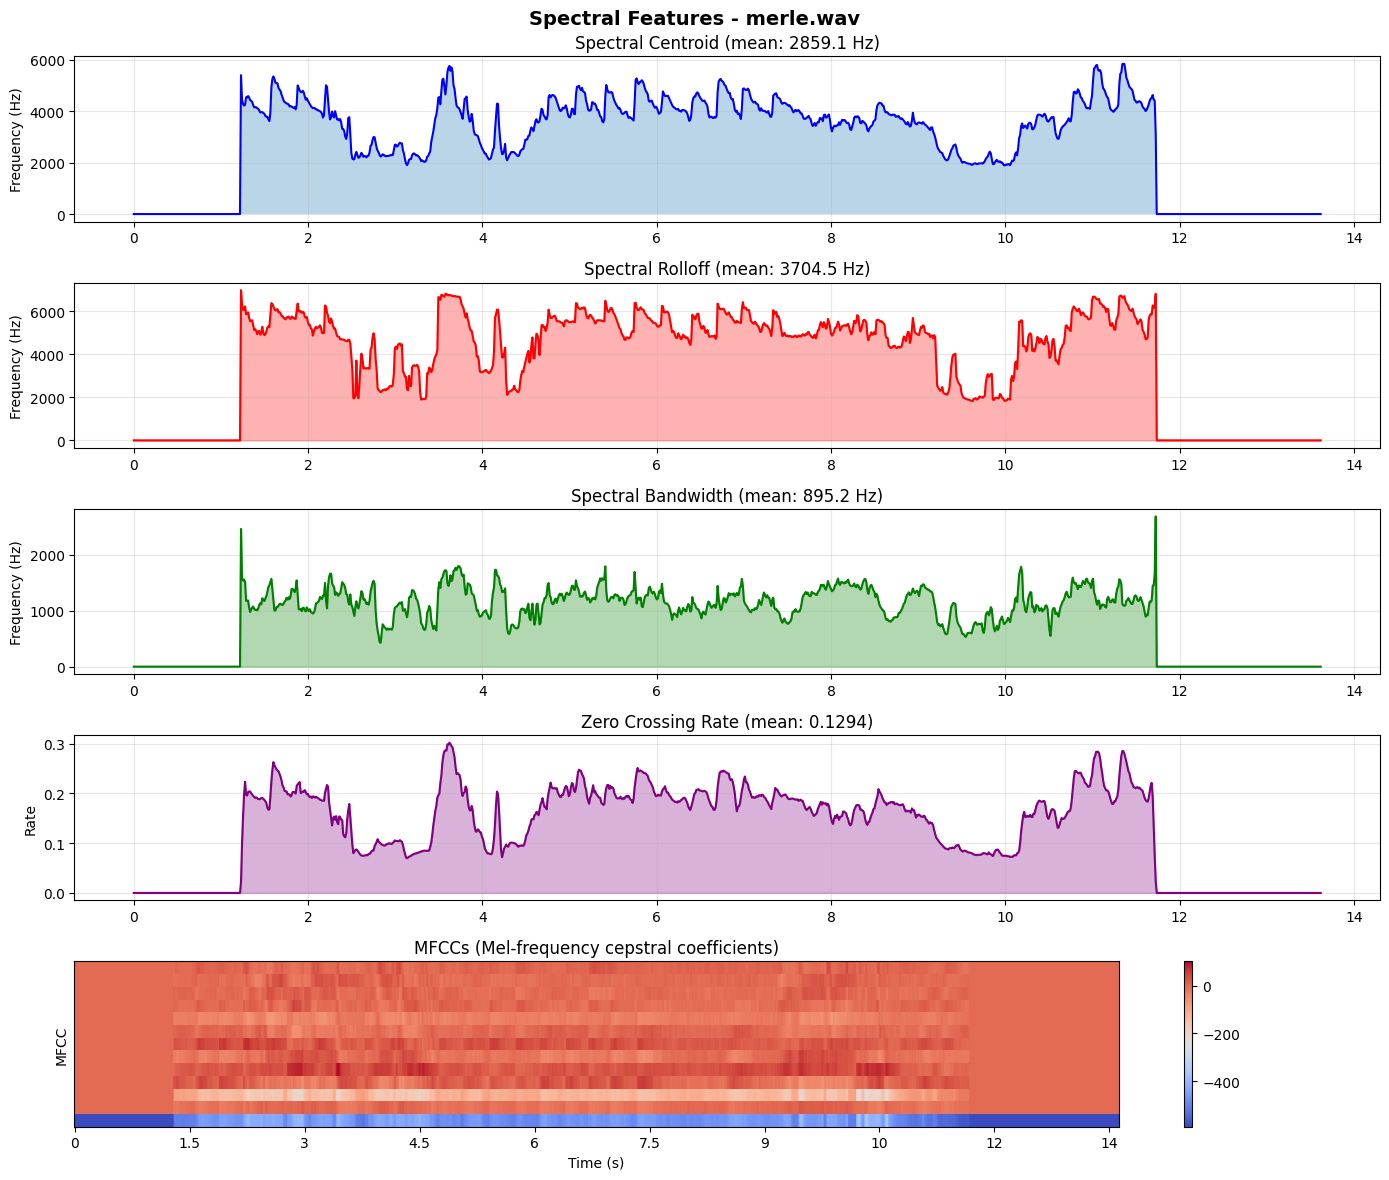

✓ Extracted features from merle.wav


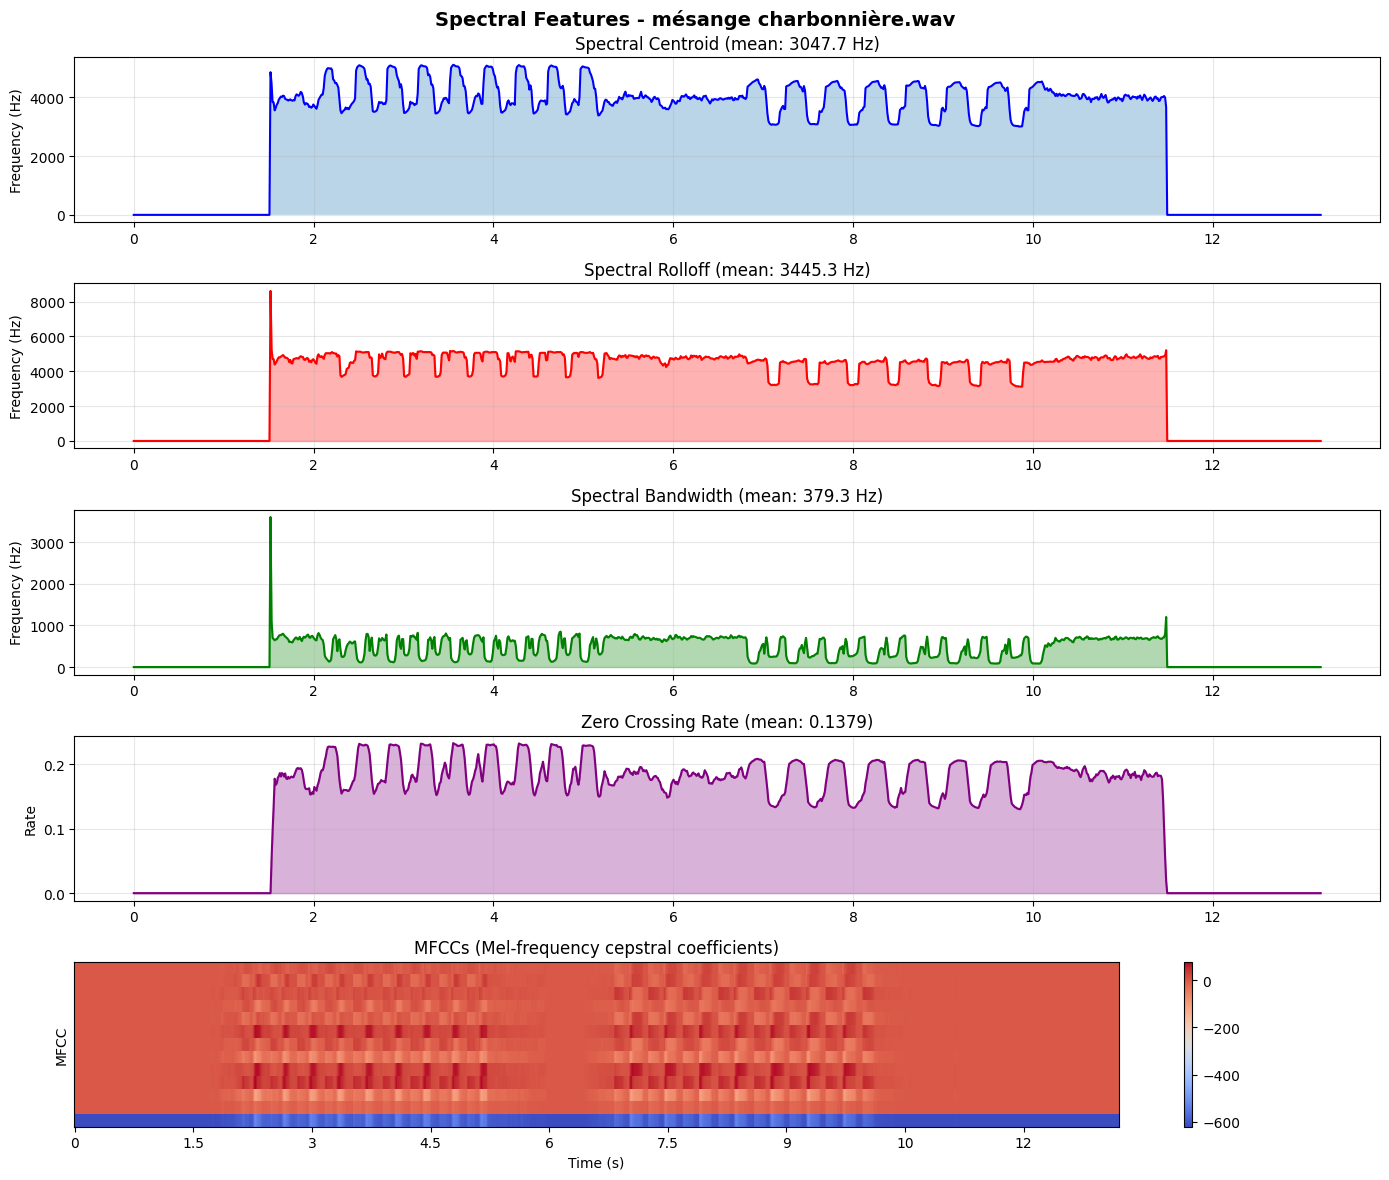

✓ Extracted features from mésange charbonnière.wav

FEATURE COMPARISON ACROSS FILES:
Filename                       Centroid     Rolloff      Bandwidth    ZCR       
----------------------------------------------------------------------------
grive.wav                          2822.8Hz     3243.7Hz      425.5Hz   0.1292
merle.wav                          2859.1Hz     3704.5Hz      895.2Hz   0.1294
mésange charbonnière.wav           3047.7Hz     3445.3Hz      379.3Hz   0.1379


[{'file': 'grive.wav',
  'centroid_mean': np.float64(2822.8206800506214),
  'centroid_std': np.float64(901.5419483601535),
  'rolloff_mean': np.float64(3243.7111549531883),
  'bandwidth_mean': np.float64(425.4856005849971),
  'zcr_mean': np.float64(0.1292225455465587),
  'mfcc_mean': array([-5.42793345e+02, -1.29003329e+00, -4.54935406e+01,  3.37831491e+00,
          3.86812424e+01, -4.15384024e+00, -2.88691129e+01,  3.22875204e+00,
          1.79469523e+01, -7.73659875e-01, -7.84439408e+00, -2.54268556e+00,
          7.42694348e-02])},
 {'file': 'merle.wav',
  'centroid_mean': np.float64(2859.1435600671807),
  'centroid_std': np.float64(1758.9028311035725),
  'rolloff_mean': np.float64(3704.51797407368),
  'bandwidth_mean': np.float64(895.1822392661547),
  'zcr_mean': np.float64(0.1294248928609455),
  'mfcc_mean': array([-499.08379813,   -3.03525728,  -97.19607038,    5.90539869,
           27.08870582,   -3.17639017,   20.99012267,   -0.80260596,
          -22.5018931 ,    0.84946682

In [14]:
def advanced_spectral_features(wav_files, folder, fs, N=1200):
    """
    Extract advanced spectral features for bird song characterization.
    
    Features:
    - Spectral Centroid: "center of mass" of spectrum
    - Spectral Rolloff: frequency below which 85% of energy lies
    - Spectral Bandwidth: weighted variance around centroid
    - Zero Crossing Rate: sign changes in signal
    - MFCCs: Mel-frequency cepstral coefficients (timbre)
    
    These features help distinguish species and individuals.
    """
    print("\n" + "="*80)
    print("ADVANCED SPECTRAL FEATURE EXTRACTION")
    print("="*80)
    
    
    all_features = []
    
    for bird_idx, filename in enumerate(wav_files[:3]):
        filepath = os.path.join(folder, filename)
        y, sr = librosa.load(filepath, sr=fs)
        bp_filter = firwin(N + 1, [lowcuts[bird_idx], highcuts[bird_idx]], pass_zero=False, fs=fs, window=window)
        
        # Apply filter
        y_filt = lfilter(bp_filter, 1.0, y)
        
        # Extract features
        centroid = librosa.feature.spectral_centroid(y=y_filt, sr=sr)[0]
        rolloff = librosa.feature.spectral_rolloff(y=y_filt, sr=sr)[0]
        bandwidth = librosa.feature.spectral_bandwidth(y=y_filt, sr=sr)[0]
        zcr = librosa.feature.zero_crossing_rate(y_filt)[0]
        mfccs = librosa.feature.mfcc(y=y_filt, sr=sr, n_mfcc=13)
        
        features = {
            'file': filename,
            'centroid_mean': np.mean(centroid),
            'centroid_std': np.std(centroid),
            'rolloff_mean': np.mean(rolloff),
            'bandwidth_mean': np.mean(bandwidth),
            'zcr_mean': np.mean(zcr),
            'mfcc_mean': np.mean(mfccs, axis=1)
        }
        all_features.append(features)
        
        # Visualization
        fig, axes = plt.subplots(5, 1, figsize=(14, 12))
        fig.suptitle(f'Spectral Features - {filename}', fontsize=14, fontweight='bold')
        
        times = librosa.times_like(centroid, sr=sr)
        
        # Spectral Centroid
        axes[0].plot(times, centroid, 'b', linewidth=1.5)
        axes[0].fill_between(times, 0, centroid, alpha=0.3)
        axes[0].set_title(f'Spectral Centroid (mean: {np.mean(centroid):.1f} Hz)')
        axes[0].set_ylabel('Frequency (Hz)')
        axes[0].grid(True, alpha=0.3)
        
        # Spectral Rolloff
        axes[1].plot(times, rolloff, 'r', linewidth=1.5)
        axes[1].fill_between(times, 0, rolloff, alpha=0.3, color='red')
        axes[1].set_title(f'Spectral Rolloff (mean: {np.mean(rolloff):.1f} Hz)')
        axes[1].set_ylabel('Frequency (Hz)')
        axes[1].grid(True, alpha=0.3)
        
        # Spectral Bandwidth
        axes[2].plot(times, bandwidth, 'g', linewidth=1.5)
        axes[2].fill_between(times, 0, bandwidth, alpha=0.3, color='green')
        axes[2].set_title(f'Spectral Bandwidth (mean: {np.mean(bandwidth):.1f} Hz)')
        axes[2].set_ylabel('Frequency (Hz)')
        axes[2].grid(True, alpha=0.3)
        
        # Zero Crossing Rate
        times_zcr = librosa.times_like(zcr, sr=sr)
        axes[3].plot(times_zcr, zcr, 'purple', linewidth=1.5)
        axes[3].fill_between(times_zcr, 0, zcr, alpha=0.3, color='purple')
        axes[3].set_title(f'Zero Crossing Rate (mean: {np.mean(zcr):.4f})')
        axes[3].set_ylabel('Rate')
        axes[3].grid(True, alpha=0.3)
        
        # MFCCs
        img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', 
                                      cmap='coolwarm', ax=axes[4])
        axes[4].set_title('MFCCs (Mel-frequency cepstral coefficients)')
        axes[4].set_ylabel('MFCC')
        fig.colorbar(img, ax=axes[4])
        
        axes[4].set_xlabel('Time (s)')
        
        plt.tight_layout()
        plt.savefig(f'spectral_features_{filename[:-4]}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Extracted features from {filename}")
    
    # Summary comparison
    print("\n" + "="*60)
    print("FEATURE COMPARISON ACROSS FILES:")
    print("="*60)
    print(f"{'Filename':<30} {'Centroid':<12} {'Rolloff':<12} {'Bandwidth':<12} {'ZCR':<10}")
    print("-"*76)
    for f in all_features:
        print(f"{f['file']:<30} {f['centroid_mean']:>10.1f}Hz {f['rolloff_mean']:>10.1f}Hz "
              f"{f['bandwidth_mean']:>10.1f}Hz {f['zcr_mean']:>8.4f}")
    
    return all_features


advanced_spectral_features(wav_files, folder, fs, N=N)

In [15]:
def generate_comprehensive_report(wav_files):
    """
    Generate a comprehensive PDF-style report summarizing all analyses.
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE ANALYSIS REPORT")
    print("="*80)
    
    report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    BIRD SONG ANALYSIS - FINAL REPORT                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Number of Files Analyzed: {len(wav_files)}
Sampling Rate: {fs} Hz
Bandpass Filter around : {np.mean(lowcuts)}-{np.mean(highcuts)} Hz
Filter Order: {N}

FILES ANALYZED:
{chr(10).join(f"  {i+1}. {f}" for i, f in enumerate(wav_files))}

METHODOLOGY:
════════════

1. PREPROCESSING & FILTERING
   - Applied FIR bandpass filter adapted to spectrum. example : Grive : ({lowcuts[0]}-{highcuts[0]} Hz)
   - Tested 9 window functions (Hamming, Hann, Blackman, etc.)
   - Optimized filter order using Kaiser formula

2. FREQUENCY ANALYSIS
   - FFT to identify dominant frequencies
   - Spectral feature extraction (centroid, rolloff, bandwidth)
   - MFCC computation for timbre analysis

3. TIME-FREQUENCY ANALYSIS
   - STFT spectrograms with multiple resolutions
   - Continuous Wavelet Transform (Morlet wavelet)
   - Compared time vs frequency resolution tradeoffs

4. DETECTION & SEGMENTATION
   - Energy-based detection with adaptive thresholding
   - Syllable segmentation and counting
   - Temporal pattern extraction



KEY FINDINGS:
═════════════
- Spectral content primarily in {np.mean(lowcuts)}-{np.mean(highcuts)} Hz range
- Filter effectively removes out-of-band noise
- Wavelet analysis provides better temporal resolution for transients
- Energy detection successfully segments syllables
- Temporal patterns show species-specific structure

RECOMMENDATIONS FOR FURTHER ANALYSIS:
═════════════════════════════════════
1. Machine learning classification using extracted features
2. Hidden Markov Models for sequence analysis
3. Dynamic Time Warping for template matching
4. Automated species identification
5. Population density estimation from multi-channel recordings

═══════════════════════════════════════════════════════════════════════════════
    """
    
    print(report)
    
   

generate_comprehensive_report(wav_files)


COMPREHENSIVE ANALYSIS REPORT

╔══════════════════════════════════════════════════════════════════════════════╗
║                    BIRD SONG ANALYSIS - FINAL REPORT                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

Analysis Date: 2025-12-14 16:52:57
Number of Files Analyzed: 10
Sampling Rate: 44100 Hz
Bandpass Filter around : 1614.618440402903-5043.097164764932 Hz
Filter Order: 1200

FILES ANALYZED:
  1. grive.wav
  2. merle.wav
  3. mésange charbonnière.wav
  4. pic vert.wav
  5. pie.wav
  6. pigeon.wav
  7. pinson.wav
  8. rouge-gorge.wav
  9. sitelle torchepot.wav
  10. tourterelle.wav

METHODOLOGY:
════════════

1. PREPROCESSING & FILTERING
   - Applied FIR bandpass filter adapted to spectrum. example : Grive : (2056.715425531915-4185.426363031916 Hz)
   - Tested 9 window functions (Hamming, Hann, Blackman, etc.)
   - Optimized filter order using Kaiser formula

2. FREQUENCY ANALYSIS
   - FFT to identify dominant frequenc